## Cytotoxic CD4+ analysis

In [4]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import pertpy
import pert2state_model
from pert2state_model.Perturb2StateModel import Perturb2StateModel

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

To download processed data:
```bash
DROPBOX_PATH=GRNPerturbSeq/3_expts/Diff035scRNAseq/
DATADIR=/mnt/oak/users/emma/data/GWT/

rclone copy dropbox:${DROPBOX_PATH}Diff035_pseudobulk.h5ad ${DATADIR} --checksum --ignore-times
rclone copy dropbox:${DROPBOX_PATH}Diff035_merged.gex.filtered.h5ad ${DATADIR} --checksum --ignore-times
```

## Load perturb-seq signatures

In [2]:
datadir = '../../../../3_expts/processed_data/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 100)] = 100
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

In [3]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
DE_stats = DE_stats[DE_stats['condition'] == 'Rest']
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

6896


### Fit model of target state from perturbations from Oh et al 2020 signature

In [46]:
oh_signature = pd.read_csv('results/oh_cytoCD4_DE_results.csv', index_col='variable')
# Only train on positive signatures
oh_signature.loc[oh_signature.zscore<0, 'zscore'] = 0

In [47]:
oh_signature

Unnamed: 0     baseMean    log_fc     lfcSE       stat  \
variable                                                           
NKG7               0   524.167232  5.711736  0.413281  13.820450   
CCL5               1  1959.664197  3.834831  0.345678  11.093647   
GZMH               2   252.437091  5.588469  0.573174   9.750043   
CCL4               3  1538.375261  4.435027  0.470944   9.417314   
GZMK               4   867.755079  3.754881  0.418680   8.968371   
...              ...          ...       ...       ...        ...   
CXorf57        17843     2.084488  0.000674  0.792246   0.000851   
SLC27A1        17844     1.414162 -0.000591  0.743749  -0.000795   
MPHOSPH6       17845    41.731604  0.000162  0.446040   0.000364   
FAM204A        17846    58.171297 -0.000022  0.228597  -0.000097   
DDX24          17847   392.780043  0.000011  0.185024   0.000058   

               p_value   adj_p_value           contrast     zscore  
variable                                                            
NKG7      1.918668e-43  2.164833e-39  cytotoxic_vs_rest  13.820450  
CCL5      1.346820e-28  7.598083e-25  cytotoxic_vs_rest  11.093647  
GZMH      1.843894e-22  6.934887e-19  cytotoxic_vs_rest   9.750043  
CCL4      4.627724e-21  1.305365e-17  cytotoxic_vs_rest   9.417314  
GZMK      3.009330e-19  6.790855e-16  cytotoxic_vs_rest   8.968371  
...                ...           ...                ...        ...  
CXorf57   9.993210e-01  9.996315e-01  cytotoxic_vs_rest   0.000851  
SLC27A1   9.993657e-01  9.996315e-01  cytotoxic_vs_rest   0.000000  
MPHOSPH6  9.997099e-01  9.998872e-01  cytotoxic_vs_rest   0.000364  
FAM204A   9.999230e-01  9.999540e-01  cytotoxic_vs_rest   0.000000  
DDX24     9.999540e-01  9.999540e-01  cytotoxic_vs_rest   0.000058  

[11283 rows x 9 columns]

In [48]:
perturb_layer = 'zscore'
ctrl_de = None
n_pcs = 60
n_splits = 5
n_repeats = 1
target_state = 'cytotoxic_vs_rest'
conds = ['Rest', 'Stim8hr', 'Stim48hr']
p2t_model_all = []
X_perturbs_all = []
y_target_all = []
signature = oh_signature

for cond in conds:
    # Get target state values
    y_target = signature[signature.contrast==target_state]['zscore'].fillna(0).copy()
    
    # Find common genes between all DE results
    common_gs = np.intersect1d(y_target.index, adata_de.var_names)
    print(f"Common genes between target and adata_de: {len(common_gs)}")
    
    y_target = y_target.loc[common_gs]
    
    # Get responses in stim cells
    print(f"Getting perturbation responses for condition: {cond}")
    X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                                ['target_contrast_gene_name'] + list(common_gs), 
                                layer=perturb_layer)
    X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
    print(f"Perturbation matrix shape: {X_perturbs.shape}")
    
    # Mask effects in cis
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    for idx in X_perturbs_masked.index:
        if idx in X_perturbs_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())
    
    # Train model on CD4 cells
    print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
    print(f"CD4 model training complete.")
    
    print(f"Model training for {target_state} completed successfully")
    p2t_model_all.append(p2t_model)
    X_perturbs_all.append(X_perturbs)
    y_target_all.append(y_target)

Common genes between target and adata_de: 9083
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (9083, 11288)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for cytotoxic_vs_rest completed successfully
Common genes between target and adata_de: 9083
Getting perturbation responses for condition: Stim8hr
Perturbation matrix shape: (9083, 11416)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for cytotoxic_vs_rest completed successfully
Common genes between target and adata_de: 9083
Getting perturbation responses for condition: Stim48hr
Perturbation matrix shape: (9083, 11282)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for cytotoxic_vs_rest completed successfully


In [49]:
oh_p2t_model_all = p2t_model_all.copy()
oh_X_perturbs_all = X_perturbs_all.copy()
oh_y_target_all = y_target_all.copy()

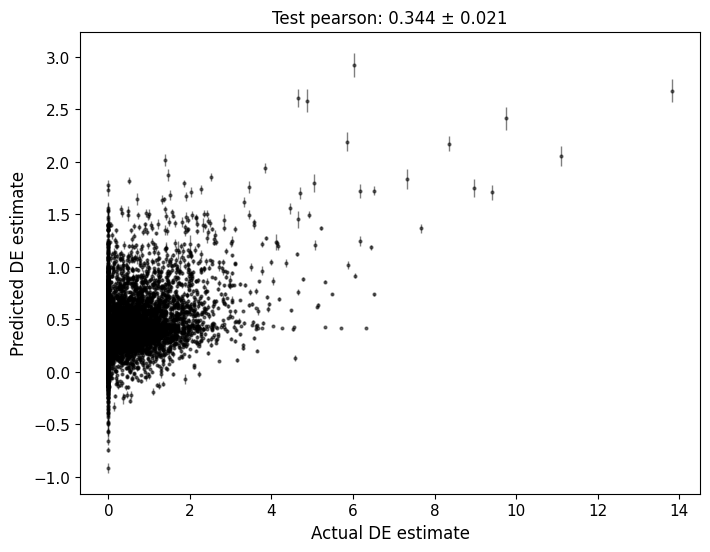

In [56]:
pl1 = p2t_model_all[2].plot_prediction(X_perturbs_all[2].fillna(0), y_target_all[2], plot_metric='pearson')

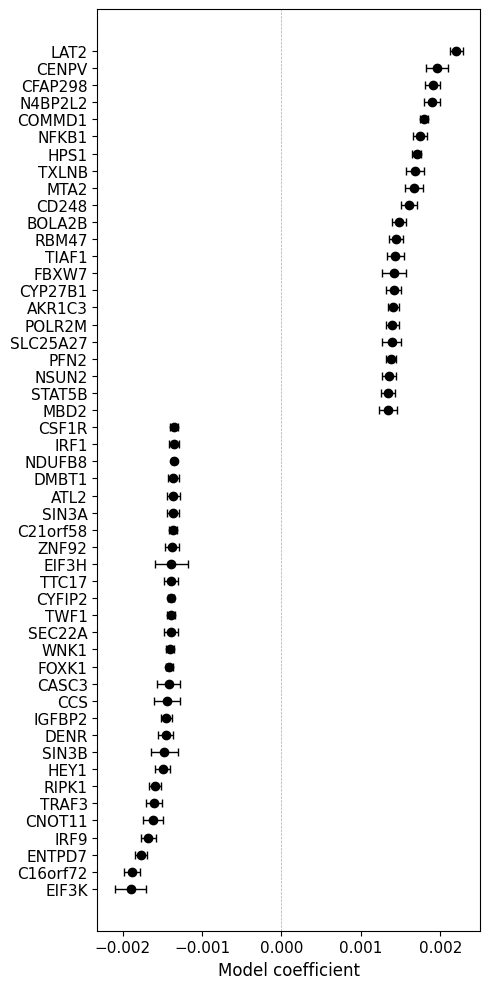

In [57]:
fig, ax = plt.subplots(figsize=(5,10))
p2t_model_all[0].plot_coefs(top_n=50, ax=ax, return_ax=True, show_labels=True)

plt.tight_layout()

In [58]:
oh_pt_coef_all = []
for i in range(3):
    oh_pt_coef_all.append(oh_p2t_model_all[i].get_coefs())

In [ ]:
X_perturbs_all

### Fit model of target state from perturbations from 1k1k signature

In [60]:
yazar_signature = pd.read_csv('results/yazar_cytoCD4_DE_results.csv', index_col='variable')
# Only train on positive signatures
yazar_signature.loc[yazar_signature.zscore<0, 'zscore'] = 0

In [61]:
perturb_layer = 'zscore'
ctrl_de = None
n_pcs = 60
n_splits = 5
n_repeats = 1
target_state = 'CytotoxicCD4'
conds = ['Rest', 'Stim8hr', 'Stim48hr']
p2t_model_all = []
X_perturbs_all = []
y_target_all = []
signature = yazar_signature

for cond in conds:
    # Get target state values
    y_target = signature[signature.contrast==target_state]['zscore'].fillna(0).copy()
    
    # Find common genes between all DE results
    common_gs = np.intersect1d(y_target.index, adata_de.var_names)
    print(f"Common genes between target and adata_de: {len(common_gs)}")
    
    y_target = y_target.loc[common_gs]
    
    # Get responses in stim cells
    print(f"Getting perturbation responses for condition: {cond}")
    X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                                ['target_contrast_gene_name'] + list(common_gs), 
                                layer=perturb_layer)
    X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
    print(f"Perturbation matrix shape: {X_perturbs.shape}")
    
    # Mask effects in cis
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    for idx in X_perturbs_masked.index:
        if idx in X_perturbs_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())
    
    # Train model on CD4 cells
    print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
    print(f"CD4 model training complete.")
    
    print(f"Model training for {target_state} completed successfully")
    p2t_model_all.append(p2t_model)
    X_perturbs_all.append(X_perturbs)
    y_target_all.append(y_target)

Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (9495, 11288)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully
Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Stim8hr
Perturbation matrix shape: (9495, 11416)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully
Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Stim48hr
Perturbation matrix shape: (9495, 11282)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully


In [62]:
yazar_p2t_model_all = p2t_model_all.copy()
yazar_X_perturbs_all = X_perturbs_all.copy()
yazar_y_target_all = y_target_all.copy()

In [63]:
yazar_pt_coef_all = []
for i in range(3):
    yazar_pt_coef_all.append(yazar_p2t_model_all[i].get_coefs())

In [64]:
pt_coef_all = oh_pt_coef_all[0].copy()
pt_coef_all.columns = ['coef_mean_oh', 'coef_sem_oh']
pt_coef_all[['coef_mean_yazar', 'coef_sem_yazar']] = yazar_pt_coef_all[0][['coef_mean', 'coef_sem']]

In [65]:
pt_coef_all

coef_mean_oh  coef_sem_oh  coef_mean_yazar  coef_sem_yazar
ABHD5        0.000172     0.000045         0.000735        0.000398
TRIO        -0.000317     0.000090        -0.001457        0.000224
CDON        -0.000531     0.000053        -0.001081        0.000114
ITCH         0.000185     0.000069         0.000276        0.000236
COL16A1      0.000144     0.000054        -0.000745        0.000350
...               ...          ...              ...             ...
ZNF442       0.000160     0.000052         0.001008        0.000157
SERF1B      -0.000182     0.000023        -0.004157        0.000252
NPTXR        0.000316     0.000078        -0.000775        0.000418
SLFN14       0.000179     0.000071         0.002705        0.000560
H2AFJ        0.000109     0.000042         0.002675        0.000308

[11288 rows x 4 columns]

coef_mean_oh  coef_mean_yazar
coef_mean_oh         1.000000         0.767225
coef_mean_yazar      0.767225         1.000000

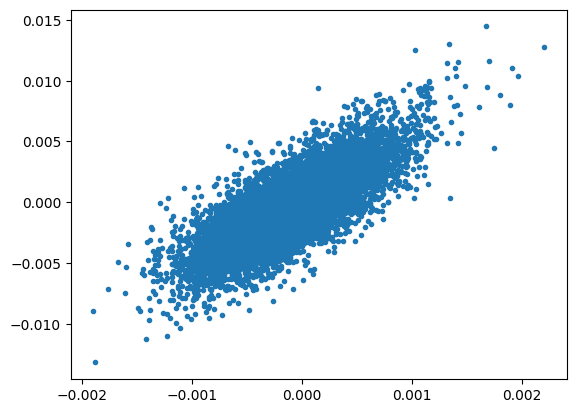

In [66]:
plt.plot(pt_coef_all['coef_mean_oh'], pt_coef_all['coef_mean_yazar'], '.')
pt_coef_all[['coef_mean_oh', 'coef_mean_yazar']].corr()

In [67]:
pt_coef_all.to_csv('results/oh_vs_yazar_cytoCD4_regulators.csv')

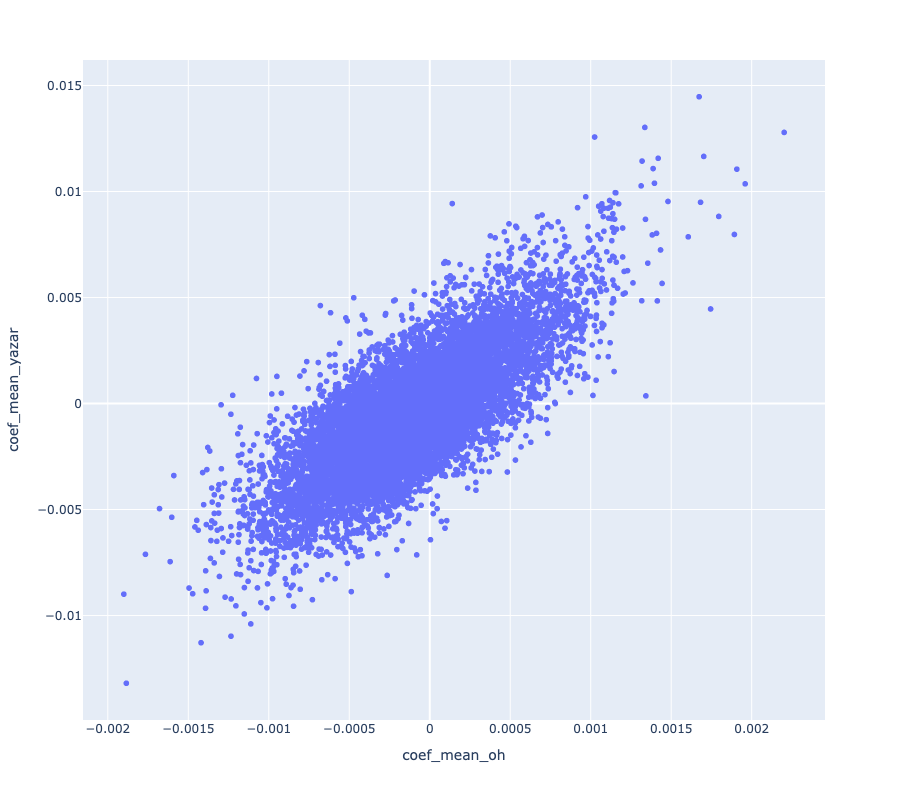

In [68]:
fig = px.scatter(
    pt_coef_all,
    x='coef_mean_oh',
    y='coef_mean_yazar',
    hover_name=pt_coef_all.index,
    width=800,
    height=800,
    opacity=1,
)
fig.show()

In [71]:
marker_gene = ['NKG7', 'PRF1', 'GZMB', 'GZMH', 'GZMK', 'GZMA']
marker_zscore = adata_de[adata_de.obs.culture_condition=='Stim8hr', adata_de.var.gene_name.isin(marker_gene)].layers['zscore']
marker_zscore_df = pd.DataFrame(data=marker_zscore, 
                                index=adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name, 
                                columns=marker_gene)
marker_zscore_df.loc[marker_gene] = 0

test = pd.merge(pt_coef_all, marker_zscore_df, left_index=True, right_index=True)

In [72]:
test

coef_mean_oh  coef_sem_oh  coef_mean_yazar  coef_sem_yazar      NKG7  \
ABHD5        0.000172     0.000045         0.000735        0.000398 -0.194282   
TRIO        -0.000317     0.000090        -0.001457        0.000224  0.079068   
CDON        -0.000531     0.000053        -0.001081        0.000114 -0.118440   
ITCH         0.000185     0.000069         0.000276        0.000236 -0.388514   
COL16A1      0.000144     0.000054        -0.000745        0.000350 -1.017234   
...               ...          ...              ...             ...       ...   
ZNF442       0.000160     0.000052         0.001008        0.000157 -0.178622   
SERF1B      -0.000182     0.000023        -0.004157        0.000252 -0.372321   
NPTXR        0.000316     0.000078        -0.000775        0.000418 -0.087049   
SLFN14       0.000179     0.000071         0.002705        0.000560  0.210228   
H2AFJ        0.000109     0.000042         0.002675        0.000308 -0.802277   

             PRF1      GZMB      GZMH      GZMK      GZMA  
ABHD5    1.644268  1.325723 -0.648392  1.038091  0.974634  
TRIO     1.975203  0.075651 -0.815702  0.715501  1.092708  
CDON     0.297048  0.688663 -0.381800 -0.306104  0.283805  
ITCH     1.630963  1.588425 -0.071915  1.062558 -0.303507  
COL16A1  1.976560  0.770797 -0.470807  0.626284  0.584075  
...           ...       ...       ...       ...       ...  
ZNF442  -0.848378  0.403732  0.045593  2.171169 -0.788304  
SERF1B   0.561485  0.198579 -0.362161  0.596351  1.275136  
NPTXR    0.921635  0.896445 -0.406320 -0.904975  2.064906  
SLFN14  -0.563512 -1.582326  0.475519 -0.545077 -0.344858  
H2AFJ    1.384661  0.775506 -0.843866  0.038386  0.449817  

[11232 rows x 10 columns]

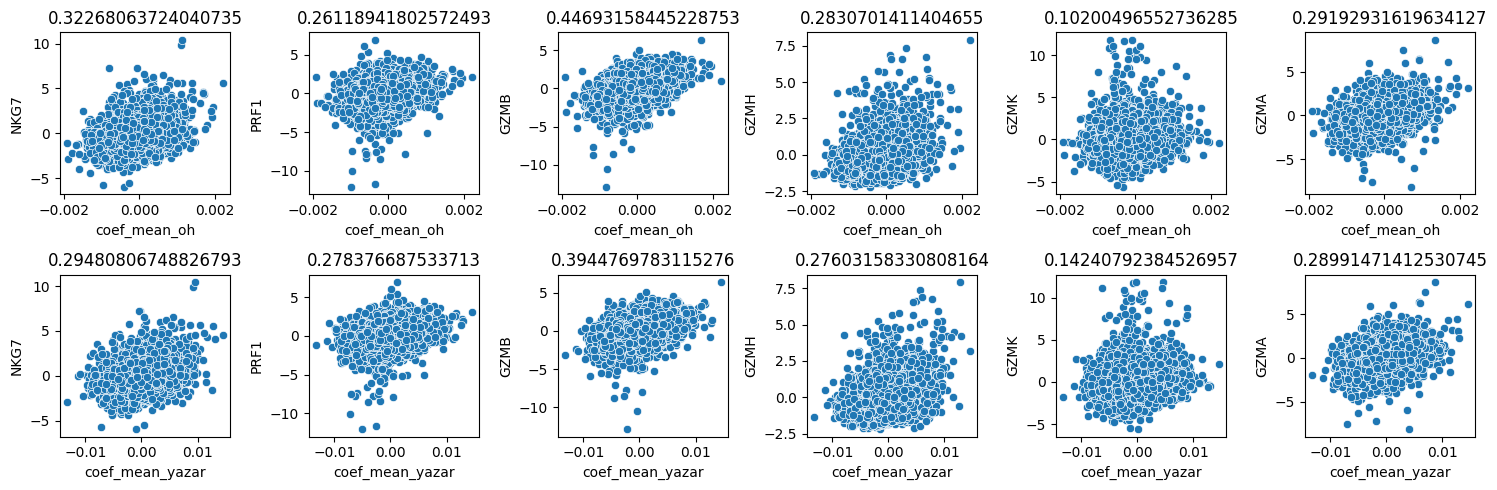

In [73]:
fig, ax = plt.subplots(2, 6, figsize=(15,5))
coef_label = ['coef_mean_oh', 'coef_mean_yazar']
for i, col in enumerate(coef_label):
    for j, marker in enumerate(marker_gene):
        sns.scatterplot(test, x=col, y=marker, ax=ax[i,j])
        ax[i,j].set_title(pearsonr(test[col], test[marker])[0])

plt.tight_layout()

In [563]:
marker_zscore_rest = adata_de[adata_de.obs.culture_condition=='Rest', adata_de.var.gene_name.isin(marker_gene)].layers['zscore']
marker_zscore_rest_df = pd.DataFrame(data=marker_zscore_rest, 
                                index=adata_de[adata_de.obs.culture_condition=='Rest'].obs.target_contrast_gene_name, 
                                columns=marker_gene)
marker_zscore_rest_df.loc[marker_gene] = 0

marker_zscore_stim8hr = adata_de[adata_de.obs.culture_condition=='Stim8hr', adata_de.var.gene_name.isin(marker_gene)].layers['zscore']
marker_zscore_stim8hr_df = pd.DataFrame(data=marker_zscore_stim8hr, 
                                index=adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name, 
                                columns=marker_gene)
marker_zscore_stim8hr_df.loc[marker_gene] = 0

In [568]:
test2 = pd.merge(marker_zscore_rest_df, marker_zscore_stim8hr_df, left_index=True, right_index=True, suffixes=('_rest', '_stim8hr'))

In [572]:
test2

TBX21_rest  GATA3_rest  IFNG_rest  IL4_rest  \
target_contrast_gene_name                                                
ABHD5                        0.156236   -0.400483  -0.032873  0.973756   
TRIO                        -0.842521    1.107740   0.180193  0.005275   
CDON                        -0.982202   -0.332034  -1.234622 -0.889477   
ITCH                         0.236650    1.002569  -0.509317  0.301596   
COL16A1                     -0.842971   -0.059751  -1.825045 -0.846392   
...                               ...         ...        ...       ...   
ZNF442                       0.288288    0.895751  -1.639520  0.353353   
SERF1B                       0.774267   -1.234073   1.834954 -0.211299   
NPTXR                       -0.144962    0.640245  -0.431369 -0.749779   
SLFN14                       0.490480   -0.269618   0.790036 -1.257254   
H2AFJ                       -0.668773   -1.296937   0.281606 -0.972748   

                           IL5_rest  IL13_rest  TBX21_stim8hr  GATA3_stim8hr  \
target_contrast_gene_name                                                      
ABHD5                     -0.944384  -1.414150       0.179575      -0.347371   
TRIO                      -0.811283  -0.002096       1.701945      -0.481060   
CDON                       0.367539  -1.022895       0.167796      -0.311006   
ITCH                      -0.667393   0.132198       0.266118       1.879991   
COL16A1                   -0.623173  -0.637200       0.148887       0.224803   
...                             ...        ...            ...            ...   
ZNF442                    -0.951879  -0.498059      -0.256332      -0.530494   
SERF1B                     0.233599   0.141310       1.412252       0.627900   
NPTXR                     -0.404269  -1.800026       0.426516       0.790986   
SLFN14                    -0.377224  -0.818605      -0.245412       1.055715   
H2AFJ                     -0.430864  -1.185769      -0.500386      -2.833623   

                           IFNG_stim8hr  IL4_stim8hr  IL5_stim8hr  \
target_contrast_gene_name                                           
ABHD5                         -0.375944    -1.092689    -3.069032   
TRIO                          -1.006430     0.169055    -1.998519   
CDON                           1.847287    -1.598804    -3.517729   
ITCH                           0.910874     0.069976     0.283396   
COL16A1                       -0.320822    -1.043702    -1.012125   
...                                 ...          ...          ...   
ZNF442                        -1.969056    -1.829010     0.768495   
SERF1B                        -2.092855    -2.311584    -2.900983   
NPTXR                          1.369372    -2.483543     0.692755   
SLFN14                         1.049527     0.769417    -0.307702   
H2AFJ                          4.430370    -0.528364    -1.772845   

                           IL13_stim8hr  
target_contrast_gene_name                
ABHD5                         -0.282528  
TRIO                           0.099467  
CDON                          -0.706020  
ITCH                           1.242052  
COL16A1                        0.166671  
...                                 ...  
ZNF442                        -1.267123  
SERF1B                        -1.050056  
NPTXR                          0.320003  
SLFN14                         0.727357  
H2AFJ                         -0.651697  

[11232 rows x 12 columns]

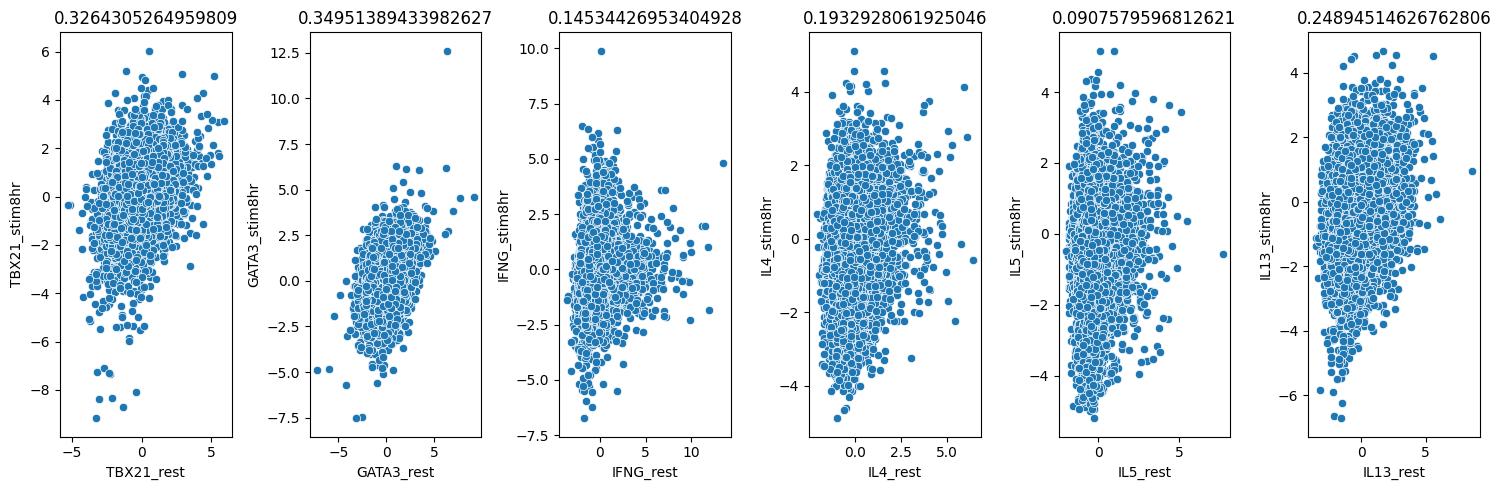

In [573]:
fig, ax = plt.subplots(1, 6, figsize=(15,5))
for i, marker in enumerate(marker_gene):
    sns.scatterplot(test2, x=marker+'_rest', y=marker+'_stim8hr', ax=ax[i])
    ax[i].set_title(pearsonr(test2[marker+'_rest'], test2[marker+'_stim8hr'])[0])

plt.tight_layout()

In [567]:
marker_zscore_stim8hr_df

TBX21     GATA3      IFNG       IL4       IL5  \
target_contrast_gene_name                                                     
UBR7                      -0.167533  2.445098  0.188583 -0.566839 -0.666386   
ATP2C1                     0.980561  0.629132 -0.500724 -2.796628  0.333365   
PRKCZ                      0.415622 -0.364605 -0.332151 -0.481262 -0.219046   
UNC13D                    -1.351891  0.607208 -1.823081  0.460202  0.087418   
PYGL                      -0.388262  1.430271 -0.420504  0.436149 -0.746069   
...                             ...       ...       ...       ...       ...   
ASPH                      -0.308811  1.841985  3.077469 -0.746308 -1.028190   
GANC                       0.353300 -0.201265  0.423923 -1.384406 -1.936669   
PRB4                       1.626976  0.055988 -1.297089 -2.662497 -2.217992   
ZNF674                     1.777654  0.740867 -0.982010 -0.321566  0.166999   
ACACA                      0.128027  0.232303  1.347158  0.493752  0.589188   

                               IL13  
target_contrast_gene_name            
UBR7                       0.583042  
ATP2C1                    -1.754801  
PRKCZ                      1.072086  
UNC13D                     0.780543  
PYGL                       0.023065  
...                             ...  
ASPH                      -0.120542  
GANC                      -3.337044  
PRB4                      -2.040175  
ZNF674                     0.114743  
ACACA                     -0.056510  

[11416 rows x 6 columns]

In [95]:
marker_gene

['NKG7', 'PRF1', 'GZMB', 'GZMH', 'GZMK', 'GZMA']

In [98]:
yazar_signature.loc[marker_gene]

baseMean    log_fc     lfcSE       stat        p_value  \
variable                                                             
NKG7      316.582538  3.261810  0.081706  39.921426   0.000000e+00   
PRF1       24.526099  2.476777  0.080576  30.738485  1.742855e-207   
GZMB       32.921222  2.402576  0.087966  27.312586  3.006557e-164   
GZMH       96.209926  4.016246  0.109921  36.537647  2.801463e-292   
GZMK       58.008815  2.428234  0.091559  26.520840  5.573801e-155   
GZMA      100.532683  2.844536  0.077539  36.685045  1.264708e-294   

            adj_p_value      contrast     zscore  
variable                                          
NKG7       0.000000e+00  CytotoxicCD4  39.921426  
PRF1      1.406775e-204  CytotoxicCD4  30.738485  
GZMB      1.532711e-161  CytotoxicCD4  27.312586  
GZMH      5.426993e-289  CytotoxicCD4  36.537647  
GZMK      2.249493e-152  CytotoxicCD4  26.520840  
GZMA      3.062490e-291  CytotoxicCD4  36.685045

### Fit model of target state from perturbations from 1k1k signature masking marker genes

In [119]:
yazar_signature = pd.read_csv('results/yazar_cytoCD4_DE_results.csv', index_col='variable')
# Only train on positive signatures
yazar_signature.loc[yazar_signature.zscore<0, 'zscore'] = 0
#yazar_signature.loc[yazar_signature.zscore>20, 'zscore'] = 0

In [122]:
len(yazar_signature.loc[yazar_signature.zscore>10])

315

In [115]:
perturb_layer = 'zscore'
ctrl_de = None
n_pcs = 60
n_splits = 5
n_repeats = 1
target_state = 'CytotoxicCD4'
conds = ['Rest', 'Stim8hr', 'Stim48hr']
p2t_model_all = []
X_perturbs_all = []
y_target_all = []
signature = yazar_signature

for cond in conds:
    # Get target state values
    y_target = signature[signature.contrast==target_state]['zscore'].fillna(0).copy()
    
    # Find common genes between all DE results
    common_gs = np.intersect1d(y_target.index, adata_de.var_names)
    print(f"Common genes between target and adata_de: {len(common_gs)}")
    
    y_target = y_target.loc[common_gs]
    
    # Get responses in stim cells
    print(f"Getting perturbation responses for condition: {cond}")
    X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                                ['target_contrast_gene_name'] + list(common_gs), 
                                layer=perturb_layer)
    X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
    print(f"Perturbation matrix shape: {X_perturbs.shape}")
    
    # Mask effects in cis
    X_perturbs_masked = X_perturbs.copy()
    mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
    for idx in X_perturbs_masked.index:
        if idx in X_perturbs_masked.columns:
            mask.loc[idx, idx] = True
    X_perturbs_masked = X_perturbs_masked.mask(mask)
    # Impute masked values with column means
    X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())
    
    # Train model on CD4 cells
    print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
    p2t_model = Perturb2StateModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')
    print(f"CD4 model training complete.")
    
    print(f"Model training for {target_state} completed successfully")
    p2t_model_all.append(p2t_model)
    X_perturbs_all.append(X_perturbs)
    y_target_all.append(y_target)

Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Rest
Perturbation matrix shape: (9495, 11288)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully
Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Stim8hr
Perturbation matrix shape: (9495, 11416)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully
Common genes between target and adata_de: 9495
Getting perturbation responses for condition: Stim48hr
Perturbation matrix shape: (9495, 11282)
Training CD4 model with 60 PCs, 5 splits, 1 repeats
CD4 model training complete.
Model training for CytotoxicCD4 completed successfully


In [116]:
yazar_mask_p2t_model_all = p2t_model_all.copy()
yazar_mask_X_perturbs_all = X_perturbs_all.copy()
yazar_mask_y_target_all = y_target_all.copy()

yazar_mask_pt_coef_all = []
for i in range(3):
    yazar_mask_pt_coef_all.append(yazar_mask_p2t_model_all[i].get_coefs())

In [117]:
pt_coef_all[['coef_mean_yazar_mask', 'coef_sem_yazar_mask']] = yazar_mask_pt_coef_all[0]

coef_mean_yazar  coef_mean_yazar_mask
coef_mean_yazar              1.000000              0.920882
coef_mean_yazar_mask         0.920882              1.000000

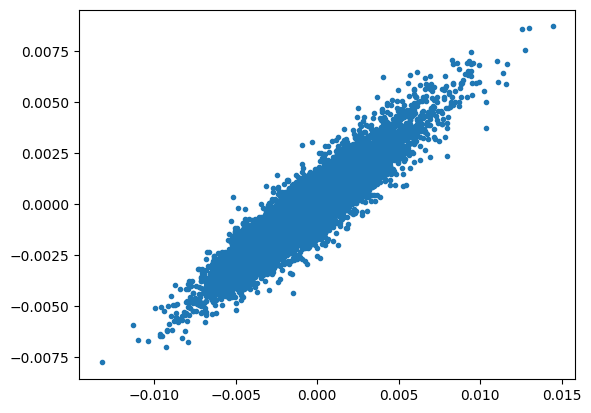

In [118]:
plt.plot(pt_coef_all['coef_mean_yazar'], pt_coef_all['coef_mean_yazar_mask'], '.')
pt_coef_all[['coef_mean_yazar', 'coef_mean_yazar_mask']].corr()

### Plot DE effects of predicted regulators

In [14]:
act_signature_df

gene_id    baseMean  log2FoldChange     lfcSE       stat  \
0      ENSG00000223972.5     0.00000             NaN       NaN        NaN   
1      ENSG00000227232.5     0.00000             NaN       NaN        NaN   
2      ENSG00000278267.1     0.00000             NaN       NaN        NaN   
3      ENSG00000243485.5     0.00000             NaN       NaN        NaN   
4      ENSG00000284332.1     0.00000             NaN       NaN        NaN   
...                  ...         ...             ...       ...        ...   
61847  ENSG00000198695.2   150.97630       -0.507438  0.139587  -3.635294   
61848  ENSG00000210194.1     1.11873        1.239681  1.146509   1.081266   
61849  ENSG00000198727.2  3185.60000       -0.601913  0.056205 -10.709160   
61850  ENSG00000210195.2    15.74130        0.288685  0.297520   0.970304   
61851  ENSG00000210196.2    68.70907        0.487442  0.152791   3.190241   

             pvalue          padj cell_type    gene_name     zscore  
0               NaN           NaN      Teff      DDX11L1        NaN  
1               NaN           NaN      Teff       WASH7P        NaN  
2               NaN           NaN      Teff    MIR6859-1        NaN  
3               NaN           NaN      Teff  MIR1302-2HG        NaN  
4               NaN           NaN      Teff    MIR1302-2        NaN  
...             ...           ...       ...          ...        ...  
61847  2.776635e-04  1.058174e-03      Teff       MT-ND6  -3.635295  
61848  2.795790e-01  4.161350e-01      Teff        MT-TE   1.081266  
61849  9.219043e-27  2.382348e-25      Teff       MT-CYB -10.709163  
61850  3.318950e-01  4.705326e-01      Teff        MT-TT   0.970304  
61851  1.421542e-03  4.690362e-03      Teff        MT-TP   3.190240  

[61852 rows x 10 columns]

In [70]:
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

In [749]:
signature_ota = pd.read_csv('results/Ota_Th2vsTh1_DE_results.csv')
signature_diff043 = pd.read_csv('results/Diff043_Th2vsTh1_DE_results.csv')
signature_diff043rest = signature_diff043[signature_diff043.contrast=='Th2_vs_Th1_Rest'].copy()
all_coef = pd.read_csv('results/ota_vs_Diff043Rest_Th2_vs_Th1_regulators.csv', index_col=0)
common_gs = set(signature_ota.variable) & set(signature_diff043rest.variable) & set(adata_de.var_names)
signature_ota_subset = signature_ota[signature_ota.variable.isin(common_gs)].copy()
signature_diff043rest_subset = signature_diff043rest[signature_diff043rest.variable.isin(common_gs)].copy()

In [750]:
num_of_sig_genes = 60
signature_gs_ota = signature_ota_subset.sort_values(by='adj_p_value').variable[:num_of_sig_genes].tolist()
signature_gs_ota = list(set(signature_gs_ota) | set(['GATA3', 'TBX21']))
signature_gs_diff043 = signature_diff043rest_subset.sort_values(by='adj_p_value').variable[:num_of_sig_genes].tolist()
signature_gs_diff043 = list(set(signature_gs_diff043) | set(['GATA3', 'TBX21']))

In [751]:
all_coef = pd.read_csv('results/ota_vs_Diff043Rest_Th2_vs_Th1_regulators.csv', index_col=0)
top_quant = 0.02

coef_label = 'coef_mean_ota'
n = len(all_coef)
top_percent = all_coef[coef_label].nlargest(int(n * top_quant))
bottom_percent = all_coef[coef_label].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_percent, bottom_percent]).sort_values(ascending=False)
predicted_regulator_ota = predicted_effect_size.index.tolist()

coef_label = 'coef_mean_Diff043'
top_percent = all_coef[coef_label].nlargest(int(n * top_quant))
bottom_percent = all_coef[coef_label].nsmallest(int(n * top_quant))
predicted_effect_size = pd.concat([top_percent, bottom_percent]).sort_values(ascending=False)
predicted_regulator_diff043 = predicted_effect_size.index.tolist()

In [752]:
predicted_regulator = list(set(predicted_regulator_ota) & set(predicted_regulator_diff043))
#predicted_regulator = predicted_regulator_diff043
predicted_regulator = predicted_regulator + ['ARRDC4', 'TMED9', 'SMARCB1', 'ACBD5', 'MEAF6']
len(predicted_regulator)

97

In [753]:
long_de_results = get_DE_results_long(adata_de, targets=predicted_regulator, genes=signature_gs_ota, gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == 'Rest'].copy()
wide_de_results = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')

long_de_results = get_DE_results_long(adata_de, targets=predicted_regulator, genes=['IFNG', 'IL4', 'IL5', 'IL13'], gene_id_col='gene_name')
long_de_results = long_de_results[long_de_results['culture_condition'] == 'Stim8hr'].copy()
wide_de_results_2 = long_de_results.pivot(index='gene', columns='target_contrast_gene_name', values='zscore')

wide_de_results = pd.concat([wide_de_results, wide_de_results_2], axis=0)

In [754]:
# Create a mask for diagonal values and low zscore values
mask = pd.DataFrame(False, index=wide_de_results.index, columns=wide_de_results.columns)
for idx in wide_de_results.index:
    if idx in wide_de_results.columns:
        mask.loc[idx, idx] = True
# Add mask for abs zscore < 1
mask = mask | (wide_de_results.abs() < 0)
wide_de_results = wide_de_results.mask(mask, 0)
wide_de_results = wide_de_results.T
wide_de_results = wide_de_results.fillna(0)

In [755]:
wide_de_results

gene                          ADRB2  APOBEC3C  APOBEC3G     ARAP2  ARHGAP26  \
target_contrast_gene_name                                                     
ACBD5                     -1.601425  1.342489 -0.684748  0.554238  0.007288   
ADCK5                     -0.423720 -0.137145  0.558188  0.264366  1.048630   
ADCY7                     -0.200213 -1.964789 -0.271029  0.618420 -1.120654   
AGPS                       0.932730  1.327829  0.912374 -0.477592  1.050973   
APOC1                     -2.430398 -1.150061 -1.608141 -0.723926  0.156451   
...                             ...       ...       ...       ...       ...   
ZNF384                    -0.710736 -0.568571 -3.259549 -0.627774  0.941397   
ZNF410                     1.016636  2.674090  2.648425  1.264059 -0.163378   
ZNF479                    -0.435820 -0.918203 -0.883467 -0.166870  0.001044   
ZNF607                     0.891101  1.152706  0.211124 -0.182642 -2.164889   
ZNF772                    -0.656339 -0.447711  0.111907  0.140868  0.183339   

gene                       C1orf162      CBLB      CCL5      CCR4      CCR5  \
target_contrast_gene_name                                                     
ACBD5                      0.860280  0.134310 -1.001544 -0.552100 -0.157659   
ADCK5                      2.560499 -0.968859 -1.167990  1.108315  0.675755   
ADCY7                      0.033798  0.693937 -0.122293  0.444936 -0.300872   
AGPS                      -0.262465 -1.603056  0.501653 -2.645957  1.746710   
APOC1                     -0.349819 -0.015049 -1.497717  1.046677 -0.947638   
...                             ...       ...       ...       ...       ...   
ZNF384                     2.401626  2.247775 -0.655445  1.116465 -1.622196   
ZNF410                     0.198307  0.197192  2.031694 -3.361042  0.589404   
ZNF479                    -0.460315 -0.575331 -1.150312  0.627130  0.013786   
ZNF607                    -0.494805  0.102250 -0.908874 -2.931884  0.327943   
ZNF772                     0.920056 -1.150362  0.021869  0.337368  0.687200   

gene                       ...    TMEM62   TNFSF11     TRGC2      WHRN  \
target_contrast_gene_name  ...                                           
ACBD5                      ... -0.101217  2.172220  1.855325 -1.713463   
ADCK5                      ... -0.746773  2.279965  1.428840 -1.279351   
ADCY7                      ... -0.462316 -0.405280 -2.234854 -0.674969   
AGPS                       ... -0.158819 -1.149786 -1.252033  0.249423   
APOC1                      ...  0.660892  0.677897 -0.146089 -0.484897   
...                        ...       ...       ...       ...       ...   
ZNF384                     ... -1.205693 -0.470015  0.056234 -0.810825   
ZNF410                     ...  0.302623 -1.248884  1.172941  2.276321   
ZNF479                     ...  0.498267  1.540741 -0.654148 -0.077589   
ZNF607                     ...  1.180600  0.627109  0.679176 -0.495397   
ZNF772                     ...  0.195753  2.412095 -0.318013 -0.655817   

gene                        ZC2HC1A    ZNF101      IFNG      IL13       IL4  \
target_contrast_gene_name                                                     
ACBD5                      0.139586 -0.790415 -2.514769  2.290927  1.474729   
ADCK5                      1.106008 -1.120895 -0.531295 -1.156097 -0.089661   
ADCY7                     -0.413033 -2.661102 -0.565176  0.822735 -0.163016   
AGPS                      -1.125393  2.133681 -0.155644 -1.572102 -1.776245   
APOC1                      0.696793 -0.095719 -0.643861 -0.062218 -0.848307   
...                             ...       ...       ...       ...       ...   
ZNF384                    -1.564045  0.109483 -0.802843  0.869063 -0.177990   
ZNF410                     0.472941  1.825991  1.062911  0.391742  1.258989   
ZNF479                     0.919242 -1.762375 -1.060148  2.857571  1.627929   
ZNF607                    -0.284064  1.322361 -0.131698 -0.604360 -0.072058   
ZNF772                     0.2852

In [756]:
predicted_regulator_annot = list(wide_de_results.index).copy()
for i, reg in enumerate(predicted_regulator_annot):
    if reg in (set(predicted_regulator_ota) & set(predicted_regulator_diff043)):
        predicted_regulator_annot[i] = reg + '_both'
    elif reg in predicted_regulator_ota:
        predicted_regulator_annot[i] = reg + '_ota'
    else:
        predicted_regulator_annot[i] = reg + '_diff043rest'

predicted_regulator = wide_de_results.index
wide_de_results.index = predicted_regulator_annot

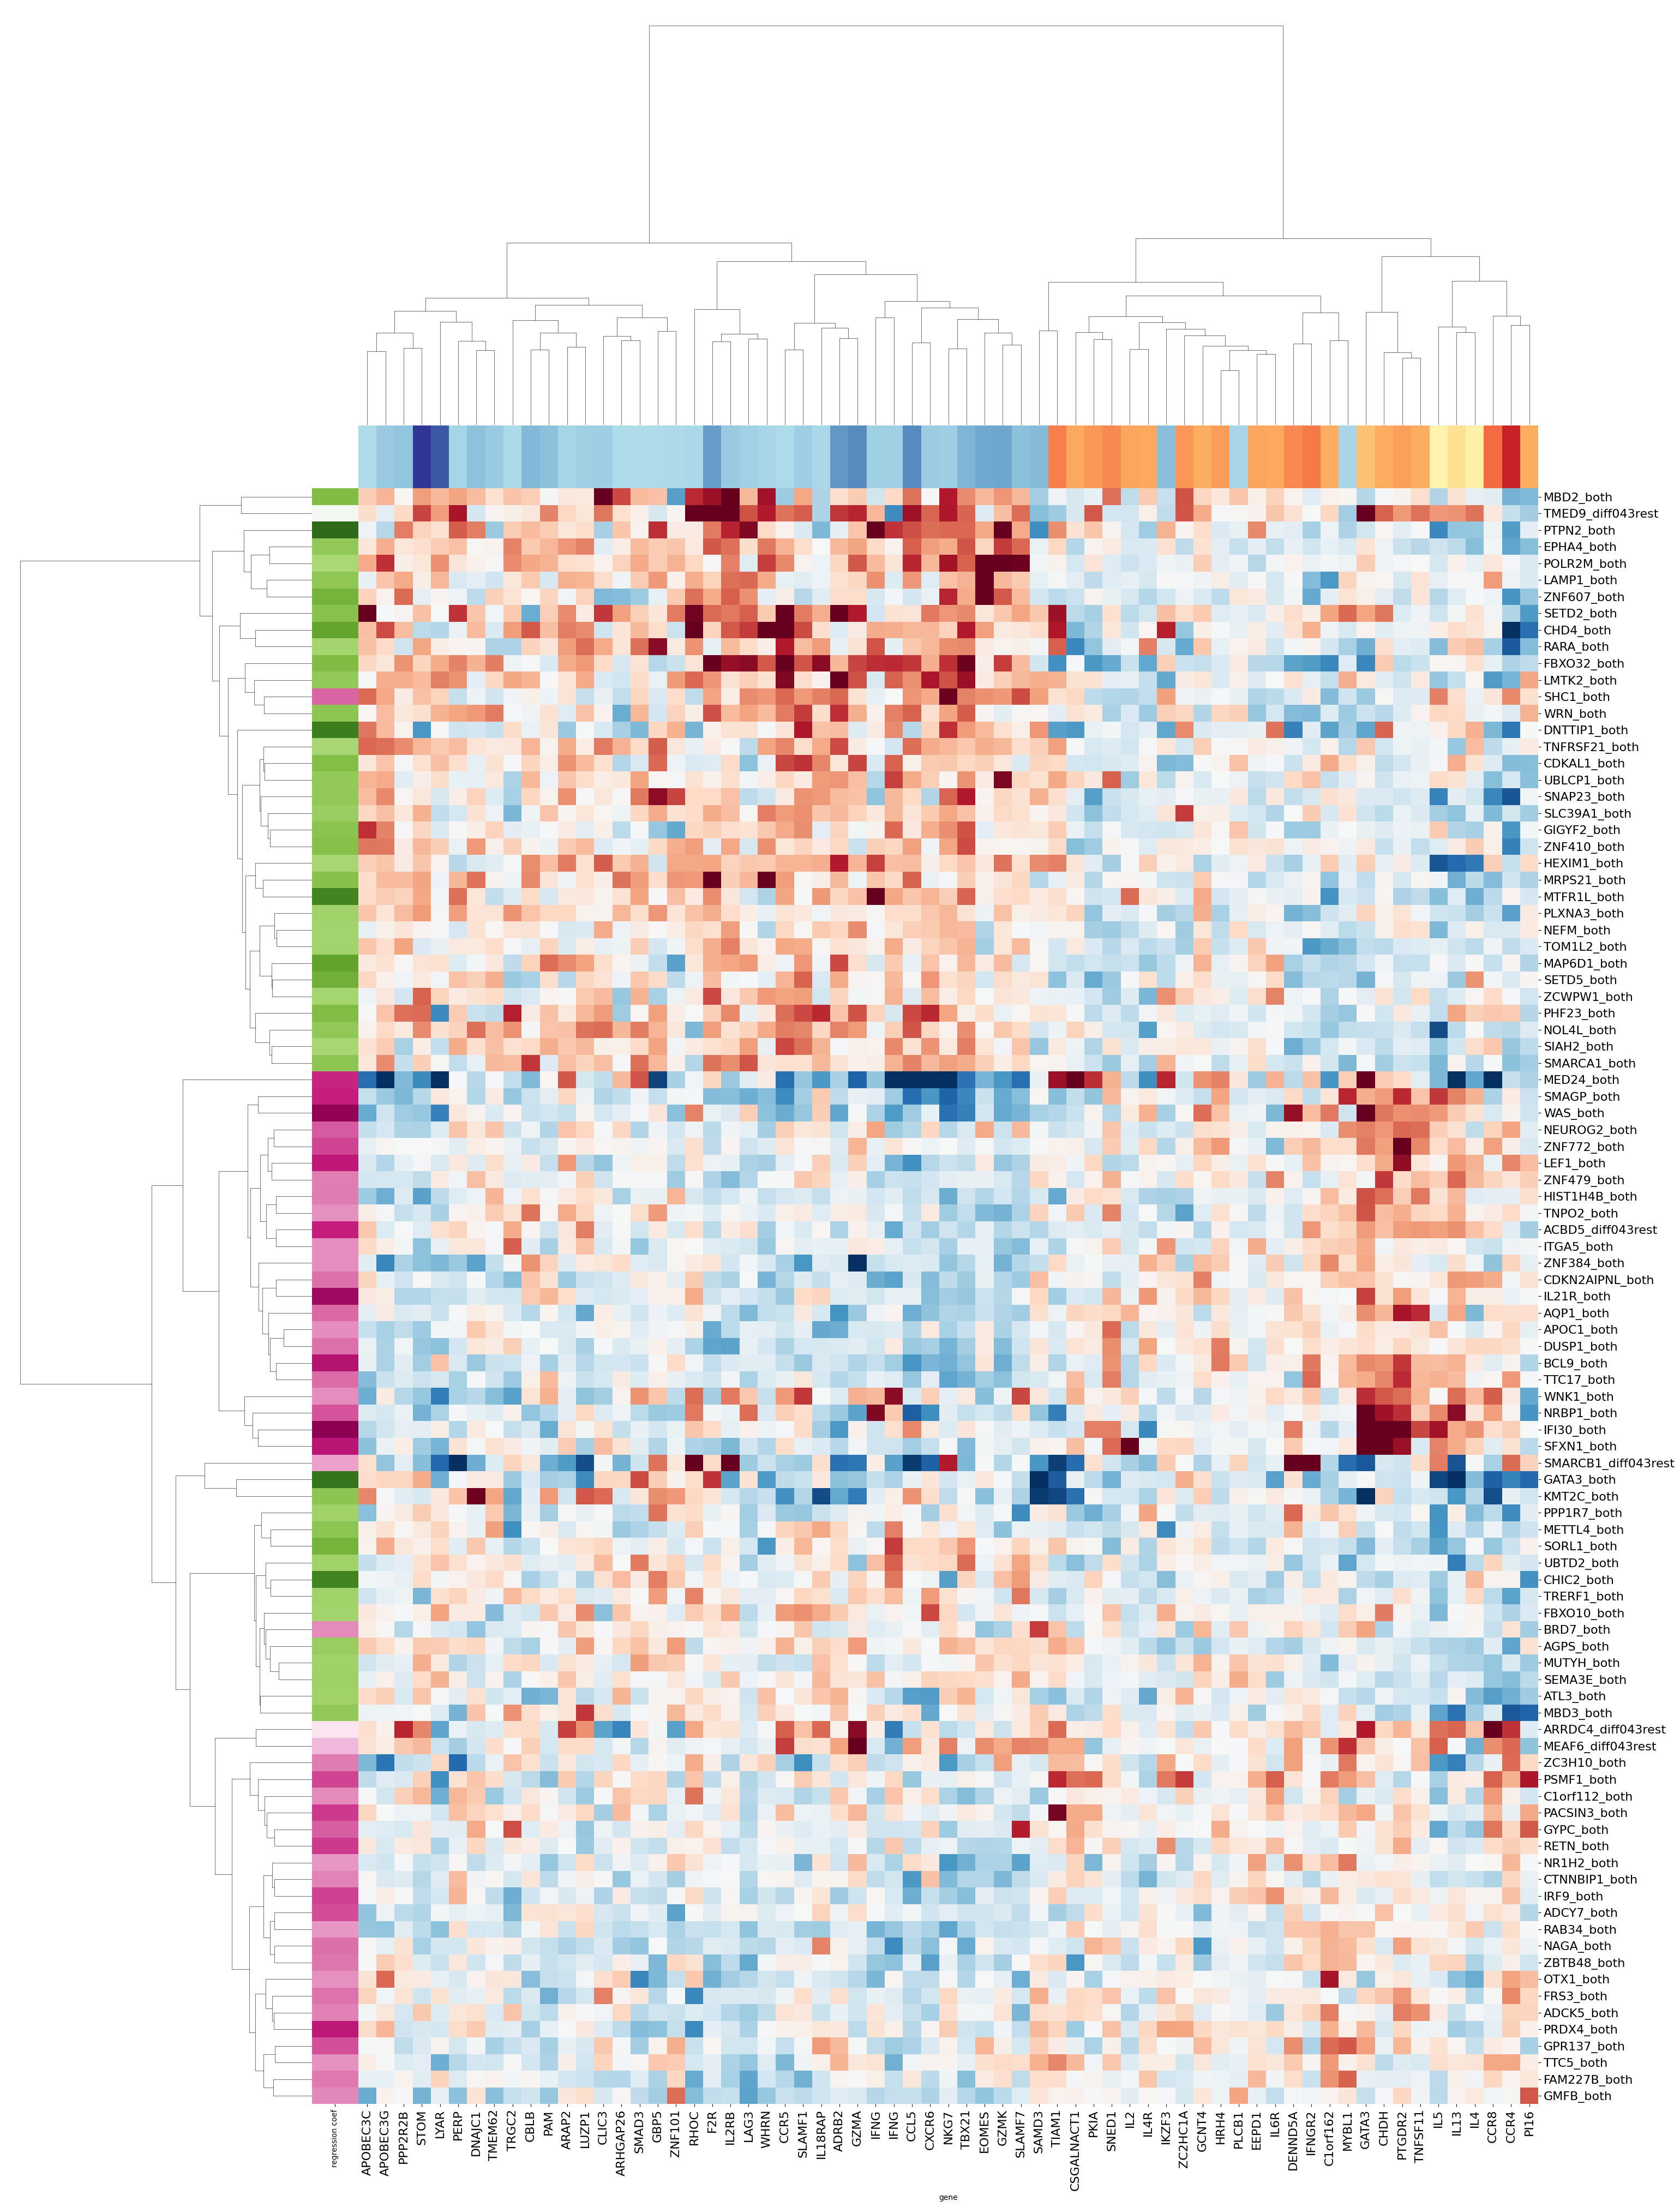

In [757]:
# Create row annotation dataframe with predicted effect sizes (now rows after transpose)
row_annot = pd.DataFrame({
    'regression coef': all_coef.loc[predicted_regulator]['coef_mean_Diff043']
})

# Create column annotation dataframe with signature zscores (now columns after transpose)
col_annot = pd.DataFrame({
    'zscore': signature_ota_subset.set_index('variable').loc[wide_de_results.columns, 'zscore'],
    'activation_gene': wide_de_results.columns.isin(activation_genes)
})

# Create different color maps for annotations
cmap_row = plt.cm.PiYG_r    # Pink-Yellow-Green for row annotation (predicted effect size)
cmap_col = plt.cm.RdYlBu_r  # Red-Yellow-Blue for column annotation (signature zscore)
cmap_activation = plt.cm.binary  # Binary colormap for activation genes

# Center the colormaps at 0 by using symmetric vmin/vmax
vmax_row = max(abs(row_annot['regression coef'].min()), abs(row_annot['regression coef'].max()))
vmax_col = max(abs(col_annot['zscore'].min()), abs(col_annot['zscore'].max()))
# Create color series for annotations (seaborn expects Series, not DataFrame with RGBA)
row_colors = row_annot['regression coef'].apply(lambda x: cmap_row((x + vmax_row) / (2 * vmax_row)))
row_colors.index = predicted_regulator_annot
col_colors = col_annot['zscore'].apply(lambda x: cmap_col((x + vmax_col) / (2 * vmax_col)))
activation_colors = col_annot['activation_gene'].apply(lambda x: cmap_activation(1.0 if x else 0.0))

# Create the clustermap
#plt.figure(figsize=(20, 15))
g = sns.clustermap(wide_de_results,
                   cmap='RdBu_r',
                   center=0,
                   row_cluster=True,
                   col_cluster=True,
                   xticklabels=True,
                   yticklabels=True,
                   method='ward',
                   figsize=(30, 40),
                   row_colors=row_colors,
                   col_colors=[col_colors],
                   vmin=-5,
                   vmax=5,
                   cbar_pos=None)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=16)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=16)

plt.savefig('../../../RZAnalysisCodes/results/commonreg+ARRDC4+TMED9+SMARCB1+ACBD5+MEAF6_otags.png')

plt.show()

In [318]:
ls ../../../

ArchivedCodes/              Untitled.ipynb
CRiIL2Stim8hr_DESeq2.ipynb  __pycache__/
GWT_perturbseq_analysis/    data/
Perturbseq_GI/              gRNA_flag.ipynb
RZAnalysisCodes/            pert2state_model/


### Combined ranking of regulators, taking into account direct regulators of TBX21, GATA3, IFNG, IL4, IL5, IL13

In [75]:
markers = ['NKG7', 'PRF1', 'GZMB', 'GZMH', 'GZMK', 'GZMA']

In [84]:
marker_zscore = adata_de[adata_de.obs.culture_condition=='Stim8hr', adata_de.var.gene_name.isin(markers)].layers['zscore']
marker_padj = adata_de[adata_de.obs.culture_condition=='Stim8hr', adata_de.var.gene_name.isin(markers)].layers['adj_p_value']
marker_zscore_df = pd.DataFrame(data=np.concatenate([marker_zscore, marker_padj],axis=1), 
                                  index=adata_de[adata_de.obs.culture_condition=='Stim8hr'].obs.target_contrast_gene_name, 
                                  columns=[marker+'_stim8hr_zscore' for marker in markers]+[marker+'_stim8hr_padj' for marker in markers])

marker_zscore = adata_de[adata_de.obs.culture_condition=='Stim48hr', adata_de.var.gene_name.isin(markers)].layers['zscore']
marker_padj = adata_de[adata_de.obs.culture_condition=='Stim48hr', adata_de.var.gene_name.isin(markers)].layers['adj_p_value']
marker_zscore_df2 = pd.DataFrame(data=np.concatenate([marker_zscore, marker_padj],axis=1), 
                                  index=adata_de[adata_de.obs.culture_condition=='Stim48hr'].obs.target_contrast_gene_name, 
                                  columns=[marker+'_stim48hr_zscore' for marker in markers]+[marker+'_stim48hr_padj' for marker in markers])

combined_df = pd.merge(marker_zscore_df, pt_coef_all[['coef_mean_oh', 'coef_mean_yazar']], left_index=True, right_index=True)
combined_df = pd.merge(combined_df, marker_zscore_df2, left_index=True, right_index=True)

In [86]:
for col in combined_df.columns:
    if 'padj' not in col:
        combined_df[col+'_rank'] = 0
        positive_mask = combined_df[col] > 0
        combined_df.loc[positive_mask, col+'_rank'] = combined_df.loc[positive_mask, col].rank(ascending=False).astype(int)
        negative_mask = combined_df[col] <= 0
        combined_df.loc[negative_mask, col+'_rank'] = -combined_df.loc[negative_mask, col].rank(ascending=True).astype(int)

In [83]:
mask1 = (combined_df['coef_mean_oh_rank'] > 0) & (combined_df['coef_mean_oh_rank'] < 100)
mask1 = mask1 & (combined_df['coef_mean_yazar_rank'] > 0) & (combined_df['coef_mean_yazar_rank'] < 100)
combined_df[mask1].to_csv('../../../RZAnalysisCodes/results/cytoCD4_regulator_list.csv')

In [93]:
mask1 = (combined_df['coef_mean_oh_rank'] < 0) & (combined_df['coef_mean_oh_rank'] > -50)
mask1 = mask1 & (combined_df['coef_mean_yazar_rank'] < 0) & (combined_df['coef_mean_yazar_rank'] > -50)
combined_df[mask1].to_csv('../../../RZAnalysisCodes/results/cytoCD4_regulator_list2.csv')

In [786]:
mask1 = (combined_df['coef_mean_ota_rank'] > 0) & (combined_df['coef_mean_ota_rank'] < 250)
mask1 = mask1 & (combined_df['coef_mean_Diff043_rank'] > 0) & (combined_df['coef_mean_Diff043_rank'] < 250)
mask1 = mask1 & (combined_df['IL5_stim8hr_zscore_rank'] > 0) & (combined_df['IFNG_stim8hr_zscore_rank'] < 0)
mask2 = (combined_df['IL5_stim8hr_zscore_rank'] > 0) & (combined_df['IL5_stim8hr_zscore_rank'] < 300)
mask2 = mask2 & (combined_df['IFNG_stim8hr_zscore_rank'] < 0) & (combined_df['IFNG_stim8hr_zscore_rank'] > -300)
mask3 = (combined_df['coef_mean_ota_rank'] > 0) & (combined_df['coef_mean_ota_rank'] < 100)
mask3 = mask3 & (combined_df['coef_mean_Diff043_rank'] > 0) & (combined_df['coef_mean_Diff043_rank'] < 100)
mask4 = (combined_df['IL5_stim8hr_zscore_rank'] > 0) & (combined_df['IL5_stim8hr_padj'] < 0.2)
mask4 = mask4 & (combined_df['IFNG_stim8hr_zscore_rank'] < 0) & (combined_df['IFNG_stim8hr_padj'] < 0.5)
combined_df[mask1 | mask2 | mask3 | mask4].to_csv('../../../RZAnalysisCodes/results/polarization_regulator_list_2.csv')

In [801]:
mask1 = (combined_df['coef_mean_ota_rank'] < 0) & (combined_df['coef_mean_ota_rank'] > -150)
mask1 = mask1 & (combined_df['coef_mean_Diff043_rank'] < 0) & (combined_df['coef_mean_Diff043_rank'] > -150)
mask1 = mask1 & (combined_df['IL5_stim8hr_zscore_rank'] < 0) & (combined_df['IFNG_stim8hr_zscore_rank'] > 0)
mask2 = (combined_df['IL5_stim8hr_zscore_rank'] < 0) & (combined_df['IL5_stim8hr_zscore_rank'] > -300)
mask2 = mask2 & (combined_df['IFNG_stim8hr_zscore_rank'] > 0) & (combined_df['IFNG_stim8hr_zscore_rank'] < 300)
mask3 = (combined_df['coef_mean_ota_rank'] < 0) & (combined_df['coef_mean_ota_rank'] > -50)
mask3 = mask3 & (combined_df['coef_mean_Diff043_rank'] < 0) & (combined_df['coef_mean_Diff043_rank'] > -50)
mask4 = (combined_df['IL5_stim8hr_zscore_rank'] < 0) & (combined_df['IL5_stim8hr_padj'] < 0.2)
mask4 = mask4 & (combined_df['IFNG_stim8hr_zscore_rank'] > 0) & (combined_df['IFNG_stim8hr_padj'] < 0.2)
combined_df[mask1 | mask2 | mask3 | mask4].to_csv('../../../RZAnalysisCodes/results/polarization_regulator_list_1.csv')

In [802]:
mask1 = (combined_df['coef_mean_ota_rank'] < 0) & (combined_df['coef_mean_ota_rank'] > -150)
mask1 = mask1 & (combined_df['coef_mean_Diff043_rank'] < 0) & (combined_df['coef_mean_Diff043_rank'] > -150)
mask1 = mask1 & (combined_df['IL5_stim8hr_zscore_rank'] < 0) & (combined_df['IFNG_stim8hr_zscore_rank'] > 0)
mask1 = mask1 & (combined_df['GATA3_rest_zscore_rank'] < 0) & (combined_df['TBX21_rest_zscore_rank'] > 0)
combined_df[mask1]

IFNG_stim8hr_zscore  IL4_stim8hr_zscore  IL5_stim8hr_zscore  \
MBD3                0.442312           -1.757647           -2.627572   
SNAP23              1.601669           -0.941255           -3.338808   
SMARCA1             1.724604           -1.388085           -2.246709   
NOL4L               1.215752            0.008341           -4.460394   
MTFR1L              1.927092           -2.433557           -2.115648   
KMT2C               0.289490           -1.396077           -0.998229   
PTPN2               3.615256           -1.937951           -3.230464   
MRPS21              1.001142           -1.348369           -0.156330   
SETD5               1.616444            2.244985           -0.304376   
CHIC2               2.661255            1.609544           -1.790665   
SLC39A1             1.666113           -0.418950           -1.692427   
MBD2                1.015571           -0.389655           -1.489726   
SORL1               3.497771           -0.070674           -2.686901   

         IL13_stim8hr_zscore  IFNG_stim8hr_padj  IL4_stim8hr_padj  \
MBD3               -3.702517           0.999999          0.695729   
SNAP23             -0.517491           0.603142          0.810950   
SMARCA1             0.167676           0.999995          0.999995   
NOL4L              -1.316001           0.929484          0.999993   
MTFR1L             -0.605698           0.999996          0.999996   
KMT2C              -2.925740           0.937496          0.595579   
PTPN2              -1.956524           0.052279          0.495019   
MRPS21             -2.392921           0.666663          0.531237   
SETD5              -1.856967           0.830633          0.606671   
CHIC2              -0.377802           0.313909          0.690184   
SLC39A1            -2.007676           0.998042          0.999780   
MBD2                0.738898           0.742565          0.941279   
SORL1              -1.931040           0.115006               NaN   

         IL5_stim8hr_padj  IL13_stim8hr_padj  TBX21_rest_zscore  \
MBD3             0.316524           0.047866           0.735865   
SNAP23           0.124452           0.915691           3.996510   
SMARCA1          0.855152           0.999995           1.859248   
NOL4L            0.037886           0.905313           2.343653   
MTFR1L           0.999996           0.999996           2.928681   
KMT2C            0.737651           0.107348           0.021282   
PTPN2            0.106777           0.489616           2.882401   
MRPS21           0.964898           0.182194           1.222360   
SETD5            0.999988           0.742325           1.115961   
CHIC2            0.632690           0.958371           1.125433   
SLC39A1          0.992078           0.939660           1.447720   
MBD2             0.503144           0.852731           2.382073   
SORL1            0.186667           0.354755           2.208228   

         GATA3_rest_zscore  ...  coef_mean_ota  coef_mean_Diff043  \
MBD3             -0.435254  ...      -0.010921          -0.008159   
SNAP23           -0.705793  ...      -0.017935          -0.008190   
SMARCA1          -0.062885  ...      -0.011243          -0.008385   
NOL4L            -1.209143  ...      -0.018656          -0.008088   
MTFR1L           -1.086121  ...      -0.015438          -0.012982   
KMT2C            -5.987493  ...      -0.014410          -0.008354   
PTPN2            -0.976529  ...      -0.011216          -0.014714   
MRPS21           -1.239564  ...      -0.012590          -0.008639   
SETD5            -2.367426  ...      -0.012913          -0.009981   
CHIC2            -1.324265  ...      -0.014987          -0.013016   
SLC39A1          -1.004724  ...      -0.015113          -0.007709   
MBD2             -1.417281  ...      -0.011081          -0.008955   
SORL1            -2.200107  ...      -0.013249          -0.009714   

         IFNG_stim8hr_zscore_rank  IL4_stim8hr_zscore_rank  \
MBD3                         2796                    -1830   
SNA

In [783]:
combined_df.loc['GATA3']

IFNG_stim8hr_zscore        -1.548536e+00
IL4_stim8hr_zscore         -2.179240e+00
IL5_stim8hr_zscore         -4.560027e+00
IL13_stim8hr_zscore        -9.515037e+00
IFNG_stim8hr_padj           3.809363e-01
IL4_stim8hr_padj            1.667347e-01
IL5_stim8hr_padj            3.092694e-04
IL13_stim8hr_padj           4.530749e-18
TBX21_rest_zscore          -3.484709e-01
GATA3_rest_zscore          -1.619672e+01
TBX21_rest_padj             9.069593e-01
GATA3_rest_padj             5.429690e-55
coef_mean_ota              -2.216885e-02
coef_mean_Diff043          -1.405518e-02
IFNG_stim8hr_zscore_rank   -1.424000e+03
IL4_stim8hr_zscore_rank    -1.089000e+03
IL5_stim8hr_zscore_rank    -2.600000e+01
IL13_stim8hr_zscore_rank   -1.000000e+00
TBX21_rest_zscore_rank     -5.004000e+03
GATA3_rest_zscore_rank     -1.000000e+00
coef_mean_ota_rank         -2.000000e+00
coef_mean_Diff043_rank     -2.000000e+00
Name: GATA3, dtype: float64

In [670]:
combined_df.loc['WAS']

IFNG_stim8hr_zscore          -2.836151
IL5_stim8hr_zscore            2.187296
IFNG_stim8hr_padj             0.086301
IL5_stim8hr_padj              0.210793
TBX21_rest_zscore            -3.392609
GATA3_rest_zscore             5.140067
TBX21_rest_padj               0.137376
GATA3_rest_padj               0.000980
coef_mean_ota                 0.014760
coef_mean_Diff043             0.014938
IFNG_stim8hr_zscore_rank   -146.000000
IL5_stim8hr_zscore_rank     190.000000
TBX21_rest_zscore_rank      -35.000000
GATA3_rest_zscore_rank        8.000000
coef_mean_ota_rank           21.000000
coef_mean_Diff043_rank        3.000000
Name: WAS, dtype: float64

In [587]:
TF_zscore_df

TBX21_rest  GATA3_rest
target_contrast_gene_name                        
ABHD5                        0.156236   -0.400483
TRIO                        -0.842521    1.107740
CDON                        -0.982202   -0.332034
ITCH                         0.236650    1.002569
COL16A1                     -0.842971   -0.059751
...                               ...         ...
ZNF442                       0.288288    0.895751
SERF1B                       0.774267   -1.234073
NPTXR                       -0.144962    0.640245
SLFN14                       0.490480   -0.269618
H2AFJ                       -0.668773   -1.296937

[11288 rows x 2 columns]

In [575]:
cytokine_zscore_df

NameError: name 'cytokine_zscore_df' is not defined

### Test prediction with individual regulators

In [410]:
# Mask effects in cis and based on zscore thresh
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
# Mask cis effects
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(0)

# Train model on CD4 cells
all_evals = []
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
for r in tqdm(predicted_regulators, desc="Training models for regulators"):
    p2t_model = Perturb2StateModel(pca_transform=False, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
    p2t_model.fit(X_perturbs_masked[[r]], y_target, model_id=f'{cond}_{r}')
    ev = p2t_model.summarize_eval()
    all_evals.append(ev)


Training CD4 model with 60 PCs, 5 splits, 1 repeats


Training models for regulators: 100%|██████████| 46/46 [00:57<00:00,  1.26s/it]


In [414]:
p2t_model = Perturb2StateModel(pca_transform=False, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked[predicted_regulators], y_target, model_id=f'{cond}_all')
ev = p2t_model.summarize_eval()
all_evals.append(ev)

/tmp/ipykernel_63633/4023652259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sorted_data, x='model_id', y='test_pearson',


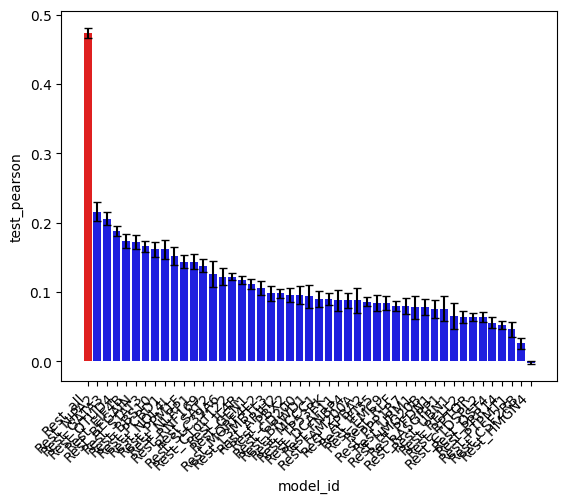

In [425]:
all_evals_df = pd.concat(all_evals)
# Sort data by test_pearson value
sorted_data = all_evals_df.sort_values('test_pearson', ascending=False).reset_index()

# Create barplot
ax = sns.barplot(data=sorted_data, x='model_id', y='test_pearson',
                palette=['red' if x == f'{cond}_all' else 'blue' for x in sorted_data['model_id']])

# Add error bars manually
x_coords = np.arange(len(sorted_data))
plt.errorbar(x=x_coords, y=sorted_data['test_pearson'],
            yerr=sorted_data['test_pearson_se'],
            fmt='none', color='black', capsize=3);

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right');

### Specificity

In [441]:
degs_y

variable
IL5      -1.0
CHDH     -1.0
IFNG      1.0
NEK6     -1.0
RCAN2     1.0
         ... 
LGALS9   -1.0
IL1R1     1.0
FN1       1.0
EMID1    -1.0
IL7R      1.0
Name: zscore, Length: 163, dtype: float64

In [494]:
(state_results_df.adj_p_value >= 0.1).astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: adj_p_value, Length: 10000, dtype: int64

In [501]:
for f in predicted_regulators:
    print(f)

SEC63
DDRGK1
DNAJB9
UFM1
CARM1
DCAF1
GEN1
GPR171
OST4
CD200
GALNT2
ACLY
SETDB1
SMARCB1
SLC25A37
C1orf122
UBA5
GDAP1
ZNF554
MYO9A
PDIA6
HS1BP3
AKIRIN1
PTPMT1
XBP1
TBPL1
C11orf58
TRMT6
CHD4
OTUD4
ANKRD11
DYRK4
NAB2
TP53RK
ENTR1
XRN1
L3MBTL3
URM1
MTM1
ADAT2
BRWD1
WARS
APBA2
CDKAL1
STAT6
IL4R


In [495]:
def calculate_tpr_fpr(all_results_df, adata_de, st='Th1', r='IL4R', cond='Stim8hr'):
    """Calculate true positive and false positive rates for matching signs between state and perturbation effects.
    
    Args:
        all_results_df: DataFrame with state results
        adata_de: AnnData object with perturbation results
        st: State to analyze (default 'Th1')
        r: Target gene (default 'IL4R') 
        cond: Culture condition (default 'Stim8hr')
        
    Returns:
        DataFrame with tpr and fpr values
    """
    # Get state results
    state_results_df = all_results_df[all_results_df['contrast'] == st].set_index('variable')
    degs_y = (state_results_df.adj_p_value >= 0.1).astype(int)

    # Get perturbation results
    long_pseq_results = get_DE_results_long(adata_de, targets=[r], gene_id_col='gene_name')
    long_pseq_results = long_pseq_results[long_pseq_results.culture_condition == cond].set_index('gene_name')
    degs_x = long_pseq_results['significant'].astype(int)

    # Get common genes and filter
    common_gs = np.intersect1d(degs_x.index, degs_y.index)
    degs_x = degs_x[common_gs]
    degs_y = degs_y[common_gs]

    # Calculate rates
    true_pos = sum((degs_x == degs_y) & (degs_y != 0))
    false_neg = sum((degs_x != degs_y) & (degs_y != 0))
    true_neg = sum((degs_x == degs_y) & (degs_y == 0))
    false_pos = sum((degs_x != degs_y) & (degs_y == 0))
    
    tpr = true_pos / (true_pos + false_neg)
    fpr = false_pos / (false_pos + true_neg)
    precision = true_pos / (true_pos + false_pos)
    
    return pd.DataFrame({'tpr': [tpr], 'fpr': [fpr], 'precision':[precision]})


all_res = []
from tqdm import tqdm
for r in tqdm(predicted_regulators, desc="Calculating TPR/FPR"):
    res = calculate_tpr_fpr(all_results_df, adata_de, st='Th1', r=r, cond='Stim8hr')
    all_res.append(res)


Calculating TPR/FPR: 100%|██████████| 46/46 [00:58<00:00,  1.26s/it]


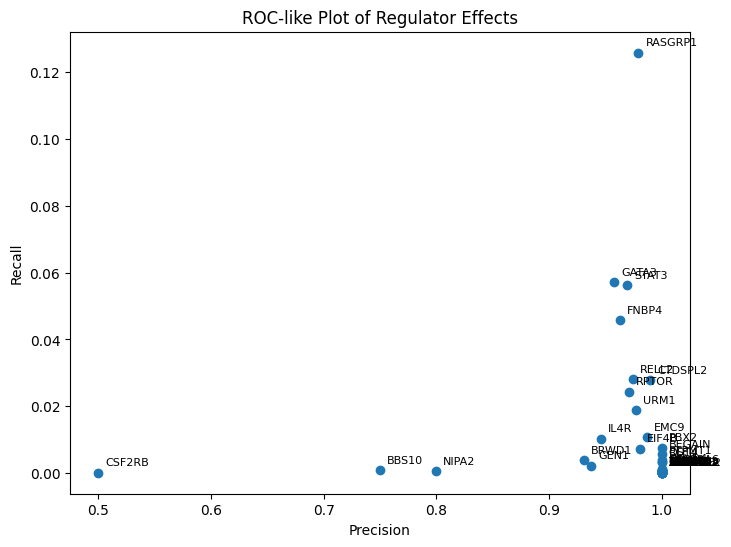

In [496]:
tpr_df = pd.concat(all_res)
tpr_df.index = predicted_regulators
plt.figure(figsize=(8,6))
scatter = plt.scatter(tpr_df['precision'], tpr_df['tpr'])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('ROC-like Plot of Regulator Effects')

# Annotate points with gene names
for gene in tpr_df.index:
    plt.annotate(gene, 
                (tpr_df.loc[gene, 'precision'], tpr_df.loc[gene, 'tpr']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8)

plt.show()

In [483]:
r = 'STAT3'
long_pseq_results = get_DE_results_long(adata_de, targets=[r], gene_id_col='gene_name')
long_pseq_results = long_pseq_results[long_pseq_results.culture_condition == cond].set_index('gene_name')
long_pseq_results['zscore'] = np.where(~long_pseq_results['significant'], 0, long_pseq_results['zscore'])
degs_x = np.sign(long_pseq_results['zscore'])

In [490]:
degs_y

variable
A4GALT    0.0
AAAS      0.0
AACS      0.0
AAK1      0.0
AAMDC     0.0
         ... 
ZWILCH    0.0
ZWINT     0.0
ZYG11A    0.0
ZYX       0.0
ZZEF1     0.0
Name: zscore, Length: 6985, dtype: float64

In [489]:
long_pseq_results[long_pseq_results['significant']]

index    gene    log_fc    zscore  adj_p_value  \
gene_name                                                                     
ABCC1      ENSG00000168610_Stim8hr   ABCC1  0.260542  3.065559     0.049715   
ABHD2      ENSG00000168610_Stim8hr   ABHD2  0.573612  2.806012     0.080653   
ABTB2      ENSG00000168610_Stim8hr   ABTB2  1.313869  3.920038     0.005173   
ACOX1      ENSG00000168610_Stim8hr   ACOX1  0.474854  3.170972     0.040651   
ACVR1B     ENSG00000168610_Stim8hr  ACVR1B -2.109128 -3.228161     0.036412   
...                            ...     ...       ...       ...          ...   
ZNF282     ENSG00000168610_Stim8hr  ZNF282 -0.482092 -2.947881     0.063021   
ZNF410     ENSG00000168610_Stim8hr  ZNF410 -0.319559 -3.682154     0.011060   
ZNF552     ENSG00000168610_Stim8hr  ZNF552  0.556947  3.085184     0.048087   
ZNRF1      ENSG00000168610_Stim8hr   ZNRF1 -1.520318 -4.030769     0.003578   
ZZEF1      ENSG00000168610_Stim8hr   ZZEF1  0.414311  3.567087     0.014487   

           significant culture_condition  target_contrast  \
gene_name                                                   
ABCC1             True           Stim8hr  ENSG00000168610   
ABHD2             True           Stim8hr  ENSG00000168610   
ABTB2             True           Stim8hr  ENSG00000168610   
ACOX1             True           Stim8hr  ENSG00000168610   
ACVR1B            True           Stim8hr  ENSG00000168610   
...                ...               ...              ...   
ZNF282            True           Stim8hr  ENSG00000168610   
ZNF410            True           Stim8hr  ENSG00000168610   
ZNF552            True           Stim8hr  ENSG00000168610   
ZNRF1             True           Stim8hr  ENSG00000168610   
ZZEF1             True           Stim8hr  ENSG00000168610   

          target_contrast_gene_name  
gene_name                            
ABCC1                         STAT3  
ABHD2                         STAT3  
ABTB2                         STAT3  
ACOX1                         STAT3  
ACVR1B                        STAT3  
...                             ...  
ZNF282                        STAT3  
ZNF410                        STAT3  
ZNF552                        STAT3  
ZNRF1                         STAT3  
ZZEF1                         STAT3  

[502 rows x 9 columns]

variable
IL5      -1.0
CHDH     -1.0
IFNG      1.0
NEK6     -1.0
RCAN2     1.0
         ... 
LGALS9   -1.0
IL1R1     1.0
FN1       1.0
EMID1    -1.0
IL7R      1.0
Name: zscore, Length: 163, dtype: float64

In [393]:
p2t_model.get_prediction(X_perturbs)['pred_mean'].loc['RCAN2']

1.0967519708525324

In [399]:
pred_effect.sort_values()

target_contrast_gene_name
C2CD4D     -0.014864
NOL4L      -0.012751
FAIM       -0.009820
PHTF2      -0.008732
ATL3       -0.008453
              ...   
LAT2        0.011613
NIPA2       0.011886
C1orf122    0.012239
FAM200A     0.013647
MCCC1       0.013741
Name: pred_mean, Length: 3861, dtype: float64

In [404]:
pred_effect.sort_values()

target_contrast_gene_name
CCAR2    -0.018933
ZNF92    -0.017845
VAMP7    -0.017169
GDAP1    -0.016994
LETMD1   -0.016668
            ...   
GATA3     0.021374
WRN       0.022866
NSG1      0.023042
NIPA2     0.023703
SAT2      0.027355
Name: pred_mean, Length: 3861, dtype: float64

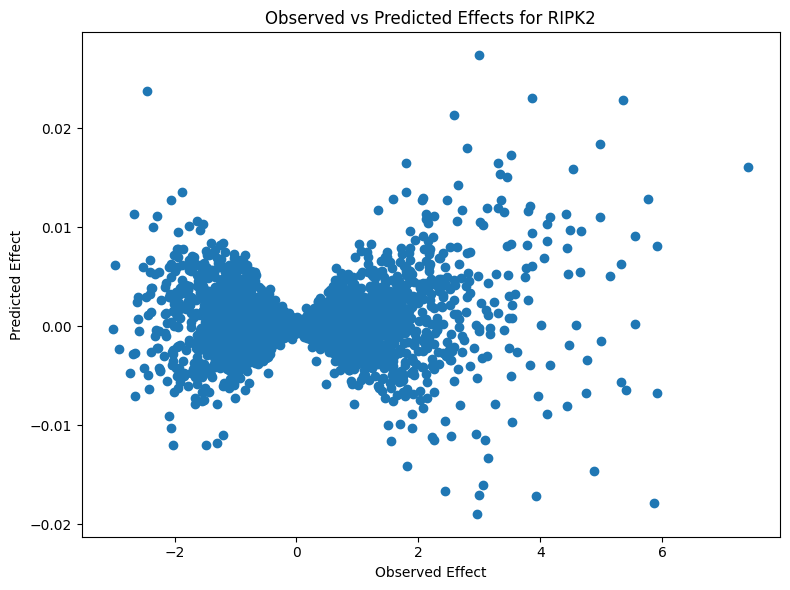

In [402]:
g = 'RIPK2'
pred_effect = p2t_model.get_effect_per_gene(X_perturbs, g)['pred_mean']
obs_effect = X_perturbs.loc[g]

plt.figure(figsize=(8,6))
plt.scatter(obs_effect, pred_effect)
plt.xlabel('Observed Effect')
plt.ylabel('Predicted Effect') 
plt.title(f'Observed vs Predicted Effects for {g}')

plt.tight_layout()
plt.show()

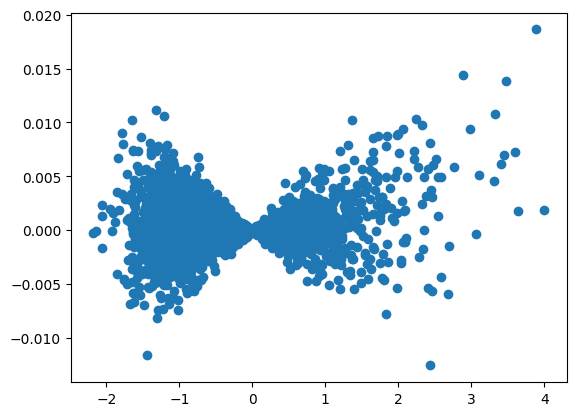

In [357]:
coefs = p2t_model.get_coefs()['coef_mean']
plt.scatter(X_perturbs.loc['RCAN2'], X_perturbs.loc['RCAN2'] * coefs)

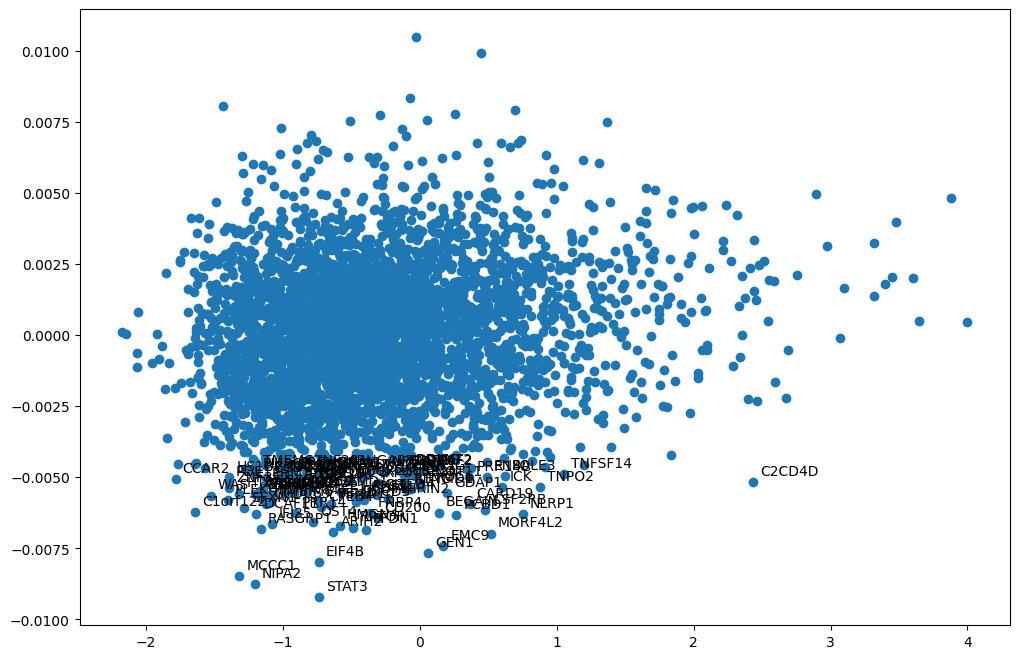

In [341]:
# Get top 5 genes with highest RCAN2 perturbation values
top_genes = p2t_model.get_coefs()['coef_mean'].nsmallest(100)

plt.figure(figsize=(12, 8))
plt.scatter(
    X_perturbs.loc['RCAN2'],
    p2t_model.get_coefs()['coef_mean'])

# Annotate top genes
for gene, value in top_genes.items():
    plt.annotate(
        gene,
        (X_perturbs.loc['RCAN2'][gene], value),
        xytext=(5, 5),
        textcoords='offset points'
    )

In [346]:
pred_df = p2t_model.get_prediction(X_perturbs, subset_regulators=[ 'MCCC1', 'NIPA2', 'STAT3', ''])
pred_df.loc['RCAN2']

pred_mean    0.031200
pred_sem     0.000378
Name: RCAN2, dtype: float64

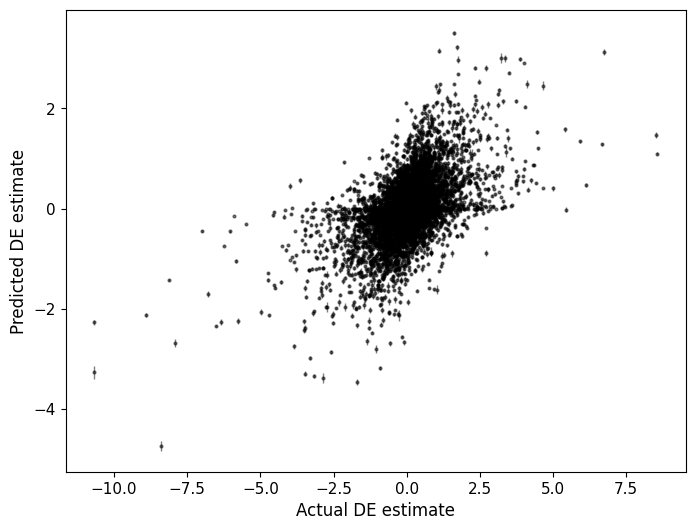

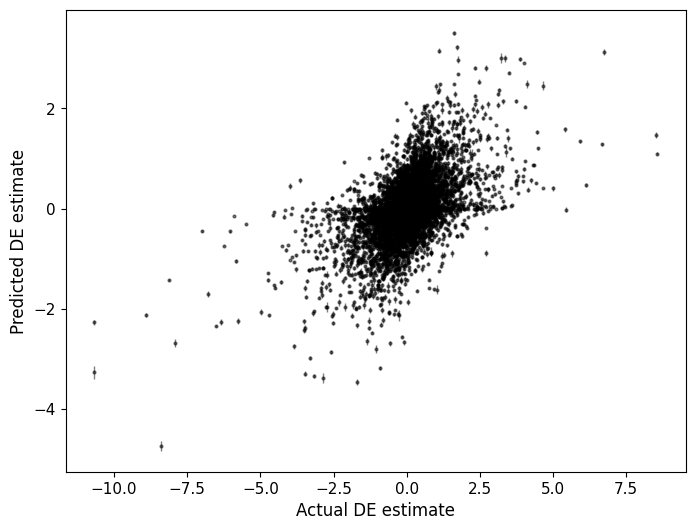

In [351]:
p2t_model.plot_prediction(X_perturbs, y_target)

In [340]:
p2t_model.plot_prediction(X_perturbs)


pred_mean    1.096752
pred_sem     0.033049
Name: RCAN2, dtype: float64

In [293]:
model_coefs = p2t_model.get_coefs()['coef_mean'].values

model_coefs

np.matmul(X_perturbs.loc['RCAN2'], model_coefs)


-1.1357412175172898

In [28]:
# Get the reordered indices after clustering
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Get the original row and column names in clustered order
clustered_row_names = wide_de_results.index[row_order]
clustered_col_names = wide_de_results.columns[col_order]

# Get the linkage matrices for further cluster analysis
row_linkage = g.dendrogram_row.linkage
col_linkage = g.dendrogram_col.linkage

# Optional: Get specific number of clusters using scipy
from scipy.cluster.hierarchy import fcluster

# Example: Get 3 clusters for rows and columns
n_row_clusters = 10
n_col_clusters = 5

row_clusters = fcluster(row_linkage, n_row_clusters, criterion='maxclust')
col_clusters = fcluster(col_linkage, n_col_clusters, criterion='maxclust')

# Create DataFrames with cluster assignments
row_cluster_df = pd.DataFrame({
    'regulator': clustered_row_names,
    'cluster': row_clusters
})

col_cluster_df = pd.DataFrame({
    'gene': clustered_col_names, 
    'cluster': col_clusters
})

print("Row clusters:")
print(row_cluster_df.groupby('cluster')['regulator'].apply(list))
print("\nColumn clusters:")
print(col_cluster_df.groupby('cluster')['gene'].apply(list))

Row clusters:
cluster
1     [RLF, TP53RK, IL4R, STAT3, FNBP4, BEGAIN, RPTO...
2     [SAMD1, SAT2, PPM1F, METTL15, UBN1, OTUD4, EIF...
3                         [ATL3, HMG20B, LETMD1, PFDN1]
4          [RELL2, OXA1L, GATA3, NLRP1, CD200, MORF4L2]
5                                              [TLNRD1]
6                                       [HS1BP3, CPEB4]
7     [ZFP41, MYO1D, FAM200A, ABTB2, APBA2, BRMS1, R...
8                                               [HMGN4]
9        [L3MBTL3, NOL4L, FAM98B, RIOK3, CSF2RB, IFI35]
10    [PPP1R7, PBX2, WARS, PTPMT1, URM1, ADORA2A, BB...
Name: regulator, dtype: object

Column clusters:
cluster
1    [CAMK2D, IL5, SMKR1, FGFBP2, GZMK, PDE4A, DUSP...
2    [SETBP1, HBEGF, TANK, MIOS, SH3RF2, ANKRD18B, ...
3    [KCNN4, TNFRSF1A, RIPK2, GZMH, ANKRD18A, RXRA,...
4    [KBTBD11, CPD, KIAA1217, RCAN2, RGS6, RNASE6, ...
5    [PRSS23, STOM, MAST4, IL18R1, IL18RAP, IRAG2, ...
Name: gene, dtype: object


### Test reconstruction accuracy for different subsets of regulators 

In [191]:

y = y_target
pred_y = p2t_model.get_prediction(X_perturbs[subset_regs])['pred_mean']
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, pred_y)
shrink_adjusted_error = np.abs(pred_y - (y*slope + intercept))
pd.concat[shrink_adjusted_error]

A4GALT    0.001190
AAAS      0.005428
AACS      0.001732
AAK1      0.004338
AAMDC     0.013968
            ...   
ZWILCH    0.008858
ZWINT     0.003676
ZYG11A    0.008459
ZYX       0.020162
ZZEF1     0.000970
Length: 6985, dtype: float64

Cluster 2 regulators: ['SAMD1', 'SAT2', 'PPM1F', 'METTL15', 'UBN1', 'OTUD4', 'EIF4B', 'GEN1', 'ARIH2', 'XYLT2', 'PRR14', 'DCAF11', 'TMBIM6']
Cluster 9 regulators: ['L3MBTL3', 'NOL4L', 'FAM98B', 'RIOK3', 'CSF2RB', 'IFI35']
Cluster 7 regulators: ['ZFP41', 'MYO1D', 'FAM200A', 'ABTB2', 'APBA2', 'BRMS1', 'RASGRP1', 'SFXN1', 'NIPA2']
Cluster 10 regulators: ['PPP1R7', 'PBX2', 'WARS', 'PTPMT1', 'URM1', 'ADORA2A', 'BBS10', 'RTRAF', 'BRWD1', 'NSG1', 'CTDSPL2', 'SLC39A6', 'RNF169', 'ANKRD26', 'EMC9', 'PCBD1', 'CBLB', 'AKIRIN2', 'OST4', 'OTUD7B']
Cluster 1 regulators: ['RLF', 'TP53RK', 'IL4R', 'STAT3', 'FNBP4', 'BEGAIN', 'RPTOR', 'PSMD10', 'HS2ST1', 'C1orf122', 'MAP3K6', 'MCCC1', 'COP1', 'PDCD5']
Cluster 3 regulators: ['ATL3', 'HMG20B', 'LETMD1', 'PFDN1']
Cluster 4 regulators: ['RELL2', 'OXA1L', 'GATA3', 'NLRP1', 'CD200', 'MORF4L2']
Cluster 5 regulators: ['TLNRD1']
Cluster 6 regulators: ['HS1BP3', 'CPEB4']
Cluster 8 regulators: ['HMGN4']


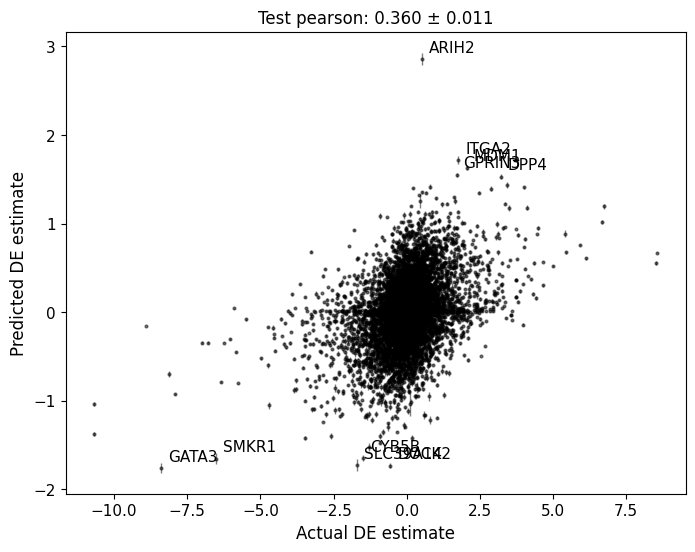

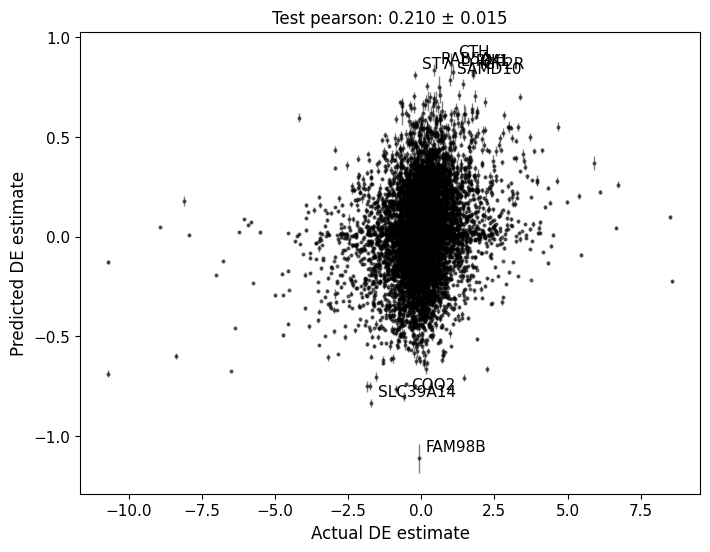

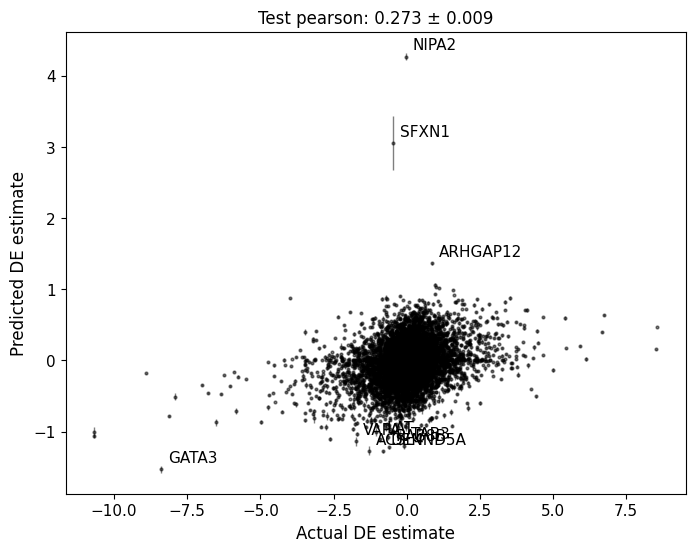

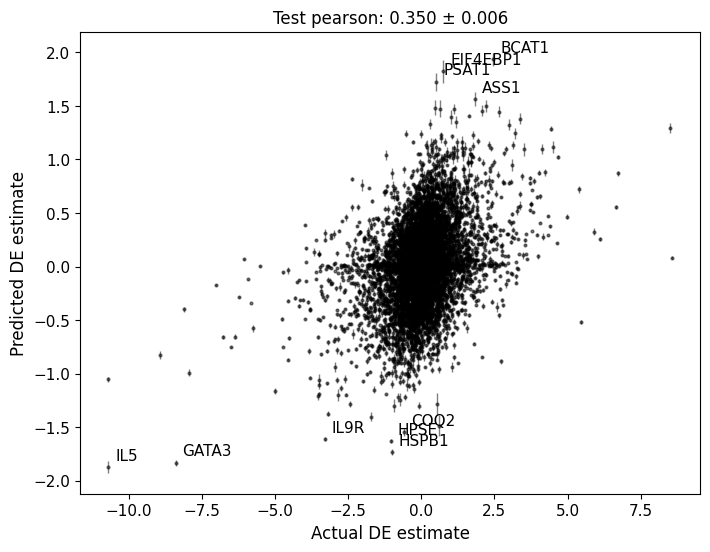

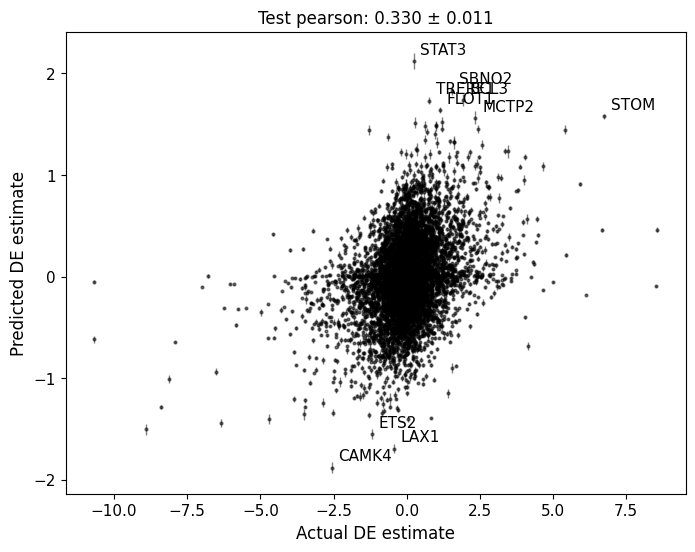

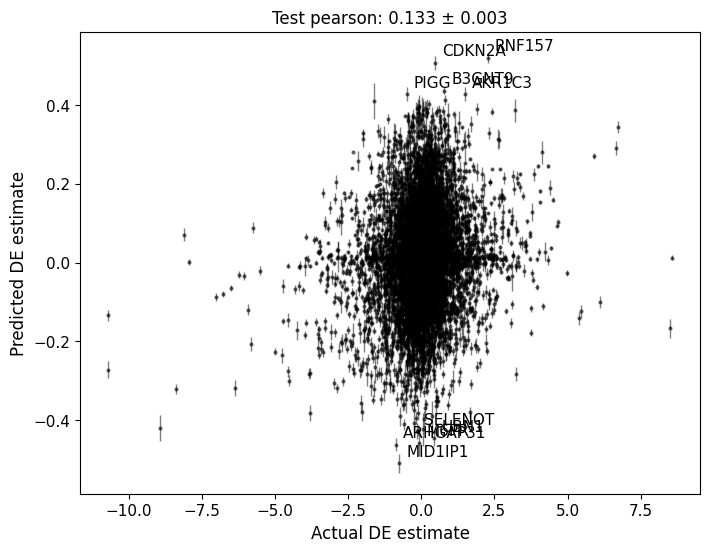

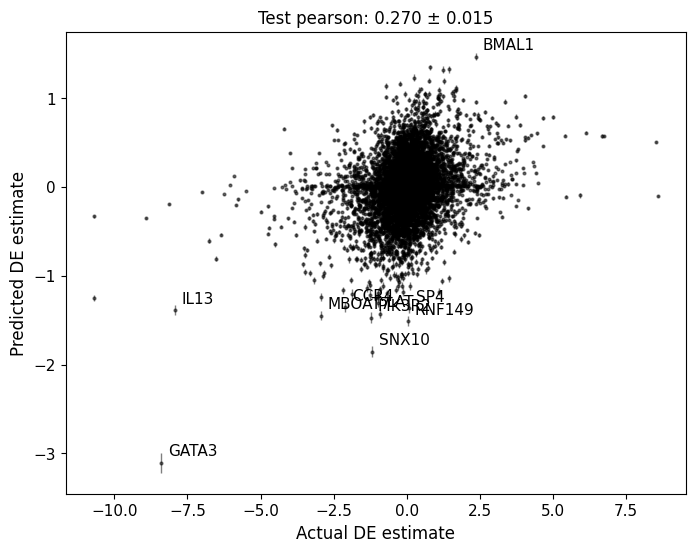

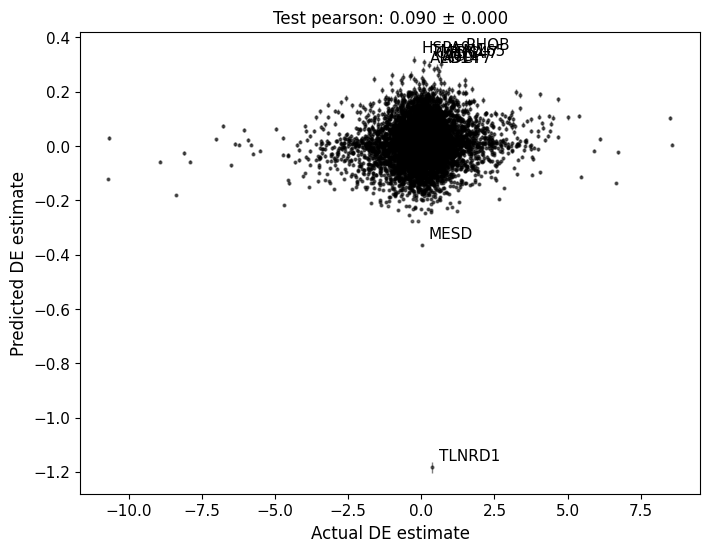

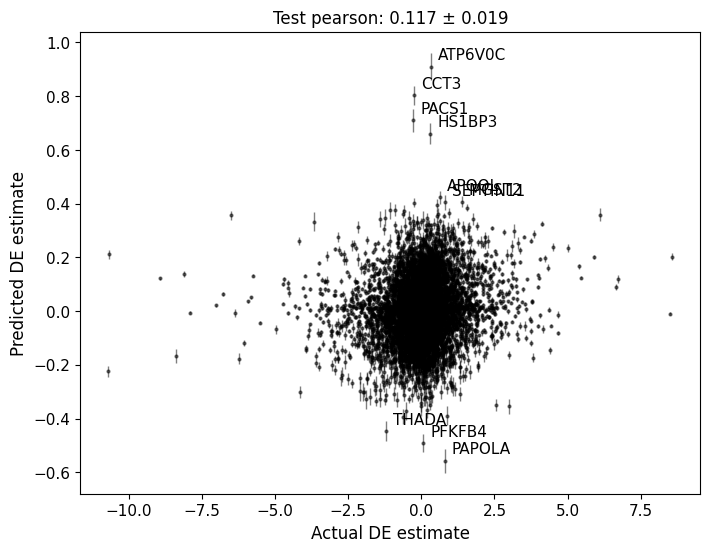

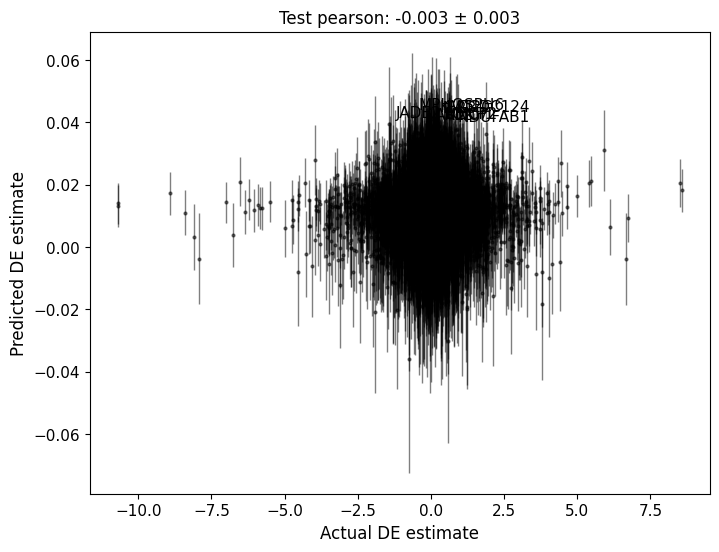

In [193]:
st = 'Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

# Initialize a list to store results for each cluster
cluster_results = []

# Iterate through clusters 1 and 2
for cluster_num in row_cluster_df['cluster'].unique():
    subset_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[cluster_num]
    print(f"Cluster {cluster_num} regulators:", subset_regs)
    
    # Fit model and get predictions
    p2t_model = Perturb2TissueModel(pca_transform=False, n_pcs=10, n_splits=3, n_repeats=1, positive=False)
    p2t_model.fit(X_perturbs[subset_regs], y_target[X_perturbs.index], model_id=f'subset_cluster_{cluster_num}')
    
    # Plot predictions 
    pl = p2t_model.plot_prediction(X_perturbs[subset_regs], y_target, annotate_top_n=10, plot_metric='pearson')
    
    # Get predictions
    preds = p2t_model.get_prediction(X_perturbs[subset_regs])
    preds['true'] = y_target
    
    # Calculate metrics
    shrink_adjusted_error = p2t_model.get_genelevel_error(X_perturbs[subset_regs], y_target[X_perturbs.index])
    
    # Add cluster number to results
    preds['cluster'] = cluster_num
    preds['shrink_adjusted_error'] = shrink_adjusted_error
    
    # Store results
    cluster_results.append(preds)

# Combine results into a single DataFrame
combined_results = pd.concat(cluster_results)


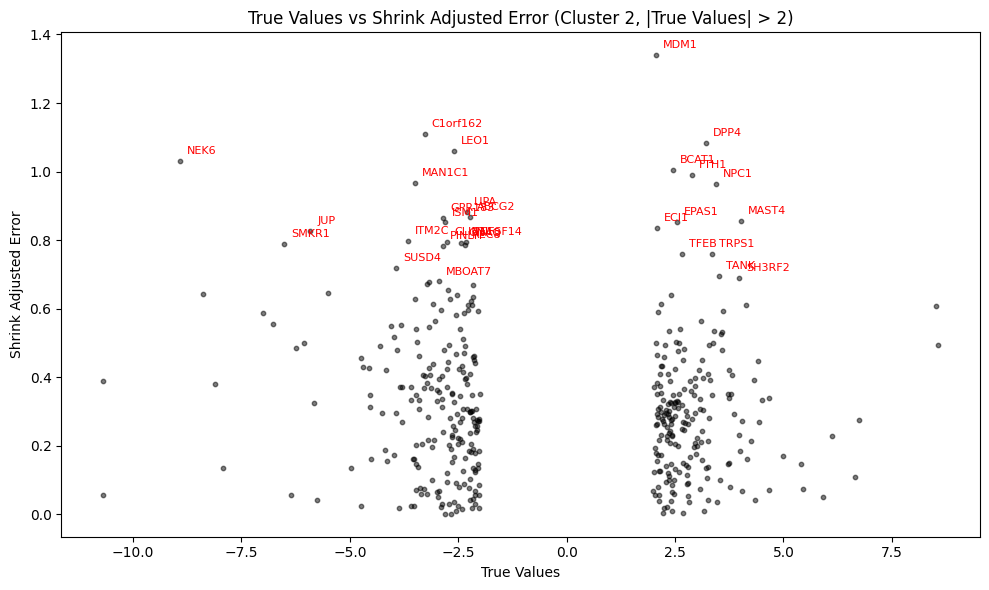

In [178]:
# Plot true values vs shrink adjusted error for cluster 2, annotating genes with highest error
cluster_2_results = combined_results[combined_results['cluster'] == 2]

# Filter to Th signature genes (true zscore > 2)
filtered_cluster_2_results = cluster_2_results[abs(cluster_2_results['true']) > 2]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_cluster_2_results['true'], filtered_cluster_2_results['shrink_adjusted_error'], alpha=0.5, color='black', s=10)
plt.xlabel('True Values')
plt.ylabel('Shrink Adjusted Error')
plt.title('True Values vs Shrink Adjusted Error (Cluster 2, |True Values| > 2)')

# Find and annotate top 10 genes with highest error
top_error_genes = filtered_cluster_2_results.nlargest(30, 'shrink_adjusted_error')
for idx, row in top_error_genes.iterrows():
    plt.annotate(idx, 
                 (row['true'], row['shrink_adjusted_error']), 
                 xytext=(5, 5), 
                 textcoords='offset points', 
                 fontsize=8,
                 color='red')

plt.tight_layout()

Compare predictions from 2 subsets of regulators

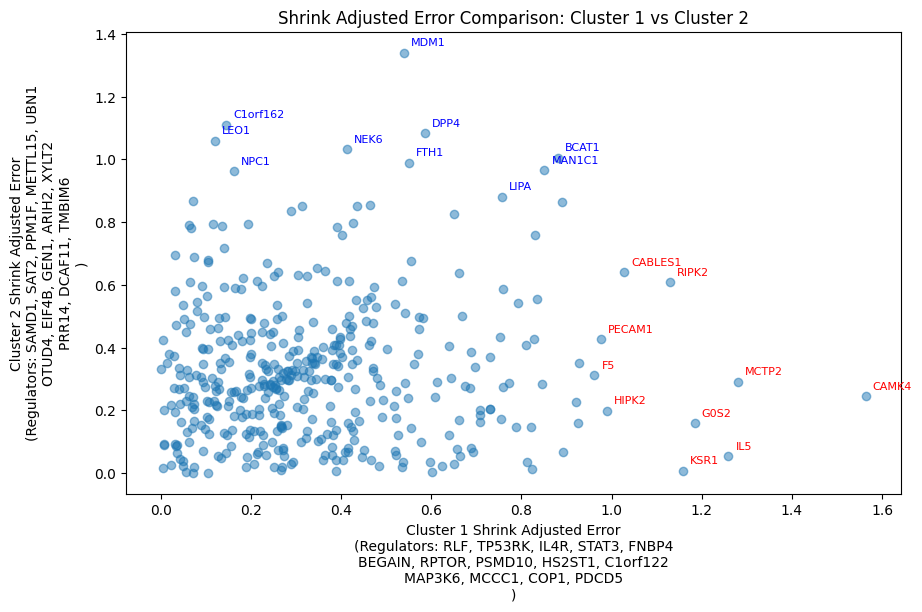

In [189]:

# Get shrink adjusted error for clusters 1 and 2, filtering to Th signature genes
cluster_1_error = combined_results[(combined_results['cluster'] == 1) & (abs(combined_results['true']) > 2)]['shrink_adjusted_error']
cluster_2_error = combined_results[(combined_results['cluster'] == 2) & (abs(combined_results['true']) > 2)]['shrink_adjusted_error']

cl1_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[1]
cl2_regs = row_cluster_df.groupby('cluster')['regulator'].apply(list)[2]

# Create a DataFrame to plot
error_comparison = pd.DataFrame({
    'Cluster 1 Error': cluster_1_error,
    'Cluster 2 Error': cluster_2_error
})

# Plot with annotations of top genes
plt.figure(figsize=(10, 6))
plt.scatter(error_comparison['Cluster 1 Error'], error_comparison['Cluster 2 Error'], alpha=0.5)
plt.xlabel(f'Cluster 1 Shrink Adjusted Error\n(Regulators: {", ".join(cl1_regs[:5])}\n{", ".join(cl1_regs[5:10])}\n{", ".join(cl1_regs[10:15])}\n{", ".join(cl1_regs[15:])})')
plt.ylabel(f'Cluster 2 Shrink Adjusted Error\n(Regulators: {", ".join(cl2_regs[:5])}\n{", ".join(cl2_regs[5:10])}\n{", ".join(cl2_regs[10:15])}\n{", ".join(cl2_regs[15:])})')
plt.title('Shrink Adjusted Error Comparison: Cluster 1 vs Cluster 2')

# Find top genes for both clusters
top_cluster_1 = combined_results[(combined_results['cluster'] == 1) & (abs(combined_results['true']) > 2)].nlargest(10, 'shrink_adjusted_error')
top_cluster_2 = combined_results[(combined_results['cluster'] == 2) & (abs(combined_results['true']) > 2)].nlargest(10, 'shrink_adjusted_error')

# Annotate top genes
for idx, row in top_cluster_1.iterrows():
    cluster_1_error_val = row['shrink_adjusted_error']
    cluster_2_error_val = cluster_2_error.loc[idx] if idx in combined_results.index else None
    plt.annotate(idx, 
                     (cluster_1_error_val, cluster_2_error_val), 
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=8,
                     color='red')

for idx, row in top_cluster_2.iterrows():
    cluster_2_error_val = row['shrink_adjusted_error']
    cluster_1_error_val = cluster_1_error.loc[idx] if idx in combined_results.index else None
    # if cluster_1_error_val is not None:
    plt.annotate(idx, 
                    (cluster_1_error_val, cluster_2_error_val), 
                    xytext=(5, 5), 
                    textcoords='offset points', 
                    fontsize=8,
                    color='blue')

# plt.tight_layout()


---

In [170]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
    


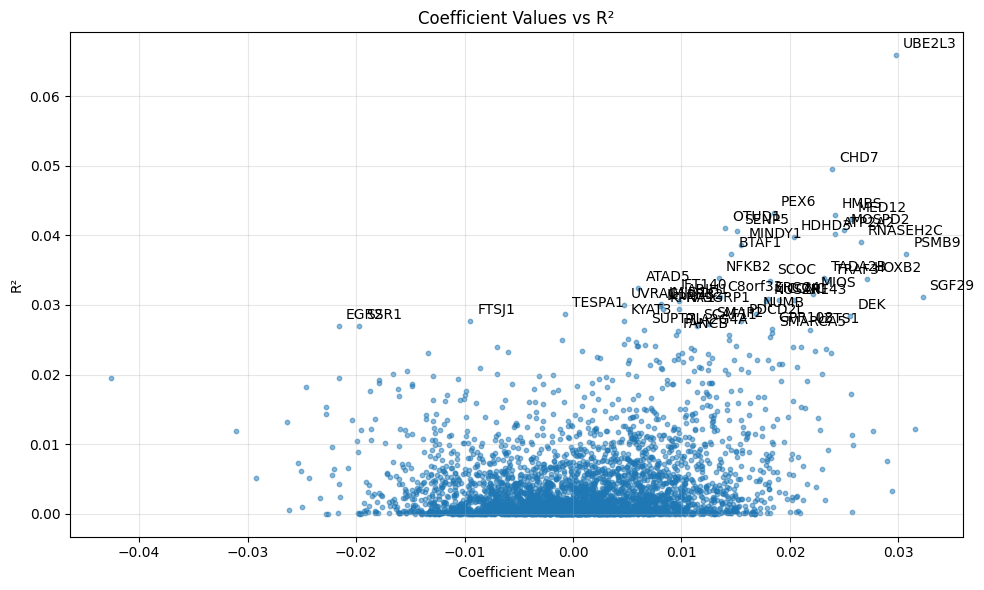

In [171]:
coefs_df = p2t_model.get_coefs()
r2_df = p2t_model.get_r2(X_perturbs, y_target)
pt_coefs = pd.concat([coefs_df, r2_df], axis=1).astype('float')
# Create scatter plot of coefficients vs r2
plt.figure(figsize=(10, 6))
plt.scatter(pt_coefs['coef_mean'], pt_coefs['r2'], alpha=0.5, s=10)

# Get top 10 genes by absolute coefficient value
top_coefs = pt_coefs['r2'].nlargest(50).index

# Add annotations for top coefficient genes
for gene in top_coefs:
    plt.annotate(gene, 
                (pt_coefs.loc[gene, 'coef_mean'], pt_coefs.loc[gene, 'r2']),
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Coefficient Mean')
plt.ylabel('R²')
plt.title('Coefficient Values vs R²')
plt.grid(True, alpha=0.3)
plt.tight_layout()


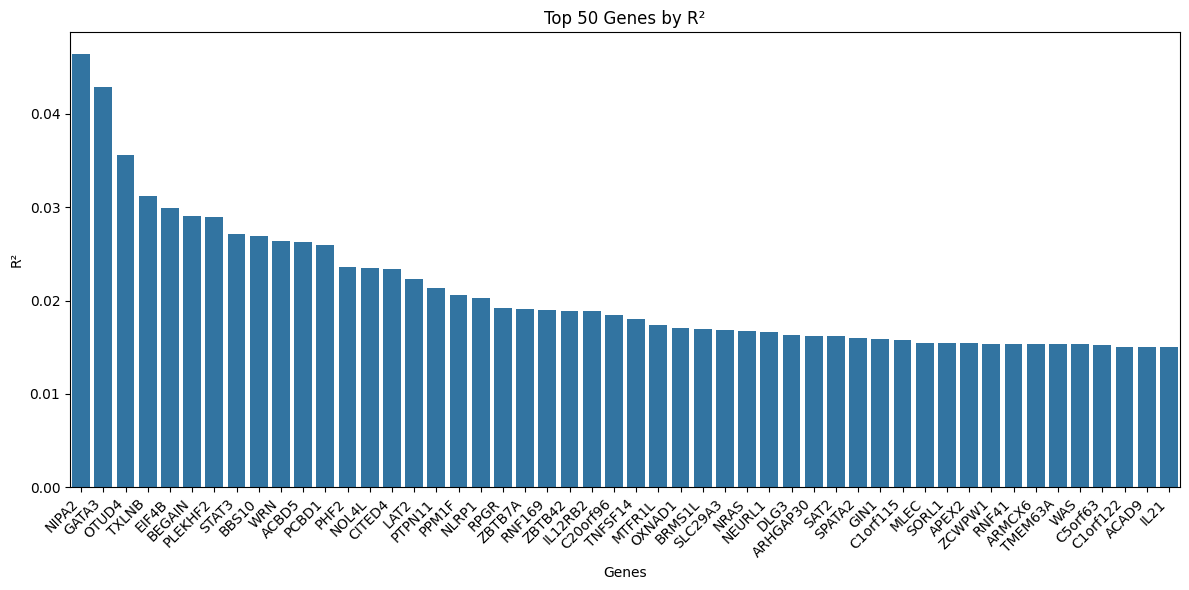

In [150]:
plt.figure(figsize=(12, 6))
sns.barplot(x=r2_top.index.tolist(), y=r2_top['r2'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genes')
plt.ylabel('R²')
plt.title('Top 50 Genes by R²')
plt.tight_layout()

In [132]:

g = 'GATA3'
st = 'Th1'

p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
pt_coefs = p2t_model.get_coefs()

# Initialize empty dataframe to store r2 values
r2_df = pd.DataFrame(index=X_perturbs.columns, columns=['r2'])

# Calculate r2 for each column
for col in X_perturbs.columns:
    # Get perturbation effects for this gene
    X_g = X_perturbs[col]
    # Mask self-perturbation and fill with mean
    X_g = X_g.mask(X_g.index == col).fillna(X_g.mean())
    # Calculate predictions using coefficients
    pred_from_g = X_g * pt_coefs['coef_mean'].loc[col]
    # Calculate correlation and r2
    corr, _ = scipy.stats.pearsonr(pred_from_g, y_target)
    r2_df.loc[col, 'r2'] = corr**2

# Sort by r2 values
r2_df = r2_df.sort_values('r2', ascending=False)
r2_df

r2
target_contrast_gene_name          
NIPA2                      0.046418
GATA3                      0.042888
OTUD4                      0.035552
TXLNB                      0.031241
EIF4B                      0.029963
...                             ...
GDF9                            0.0
AHCYL1                          0.0
CNOT6L                          0.0
IQCC                            0.0
ARF1                            0.0

[3861 rows x 1 columns]

<Axes: xlabel='coef_mean', ylabel='r2'>

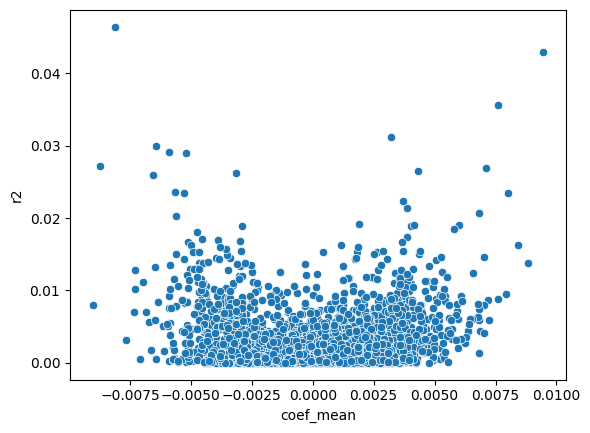

In [ ]:
pt_coefs['r2'] = r2_df['r2']
sns.scatterplot(data=pt_coefs, x='coef_mean', y='r2')

In [139]:
pt_coefs.sort_values('r2', ascending=False)[0:40]

coef_mean  coef_sem        r2
NIPA2     -0.008121  0.000211  0.046418
GATA3      0.009467  0.000254  0.042888
OTUD4      0.007609  0.000096  0.035552
TXLNB      0.003214  0.000244  0.031241
EIF4B     -0.006426  0.000105  0.029963
BEGAIN    -0.005919  0.000239  0.029107
PLEKHF2   -0.005194  0.000255  0.028973
STAT3     -0.008712  0.000355  0.027131
BBS10      0.007118  0.000190  0.026897
WRN        0.004310  0.000237  0.026432
ACBD5     -0.003156  0.000218  0.026247
PCBD1     -0.006560  0.000235  0.025934
PHF2      -0.005640  0.000139   0.02365
NOL4L      0.008025  0.000598  0.023486
CITED4    -0.005288  0.000129  0.023396
LAT2       0.003685  0.000347  0.022288
PTPN11     0.003877  0.000293  0.021394
PPM1F      0.006842  0.000262  0.020645
NLRP1     -0.005625  0.000343  0.020324
RPGR       0.001877  0.000137  0.019173
ZBTB7A     0.004173  0.000062  0.019091
RNF169     0.005991  0.000149  0.019047
ZBTB42    -0.002919  0.000256  0.018915
IL12RB2    0.004046  0.000177  0.018857
C20orf96   0.005813  0.000245  0.018496
TNFSF14   -0.004759  0.000040   0.01805
MTFR1L     0.003853  0.000133  0.017373
OXNAD1    -0.004527  0.000256  0.017117
BRMS1L    -0.003904  0.000166  0.017009
SLC29A3   -0.003002  0.000279  0.016885
NRAS       0.003669  0.000405  0.016737
NEURL1    -0.005107  0.000283   0.01666
DLG3       0.001173  0.000282  0.016294
ARHGAP30  -0.004986  0.000245  0.016259
SAT2       0.008425  0.000105  0.016226
SPATA2     0.001873  0.000182  0.015965
GIN1      -0.003789  0.000174  0.015928
C1orf115  -0.003541  0.000092  0.015733
MLEC      -0.002960  0.000343  0.015472
SORL1      0.004396  0.000166  0.015468

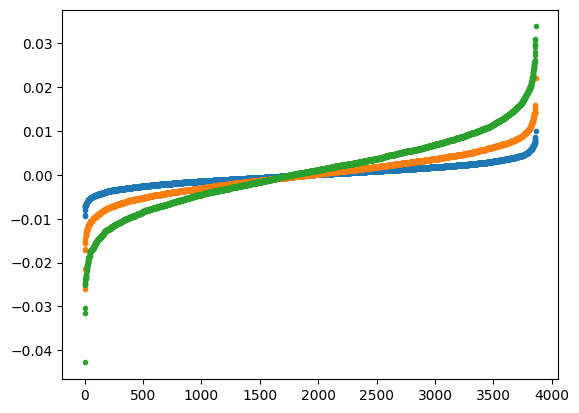

In [408]:
plt.plot(coefs_wide['Th1'].sort_values().values, '.')
plt.plot(coefs_wide['Th2'].sort_values().values, '.')
plt.plot(coefs_wide['Treg'].sort_values().values, '.')

In [251]:
# Normalize each row to sum to 1
coefs_wide_norm = coefs_wide.apply(lambda x: x - x.min(), axis=1)
# Get top 20 absolute values for each column and save in a list
top_genes_list = []
for col in coefs_wide_norm.columns:
    # Get absolute values and sort
    abs_values = coefs_wide_norm[col].abs().sort_values(ascending=False)
    # Get top 20 gene names and values
    top_20 = [gene for gene in abs_values.head(50).index]
    top_genes_list.extend(top_20)

top_genes_list = list(set(top_genes_list))


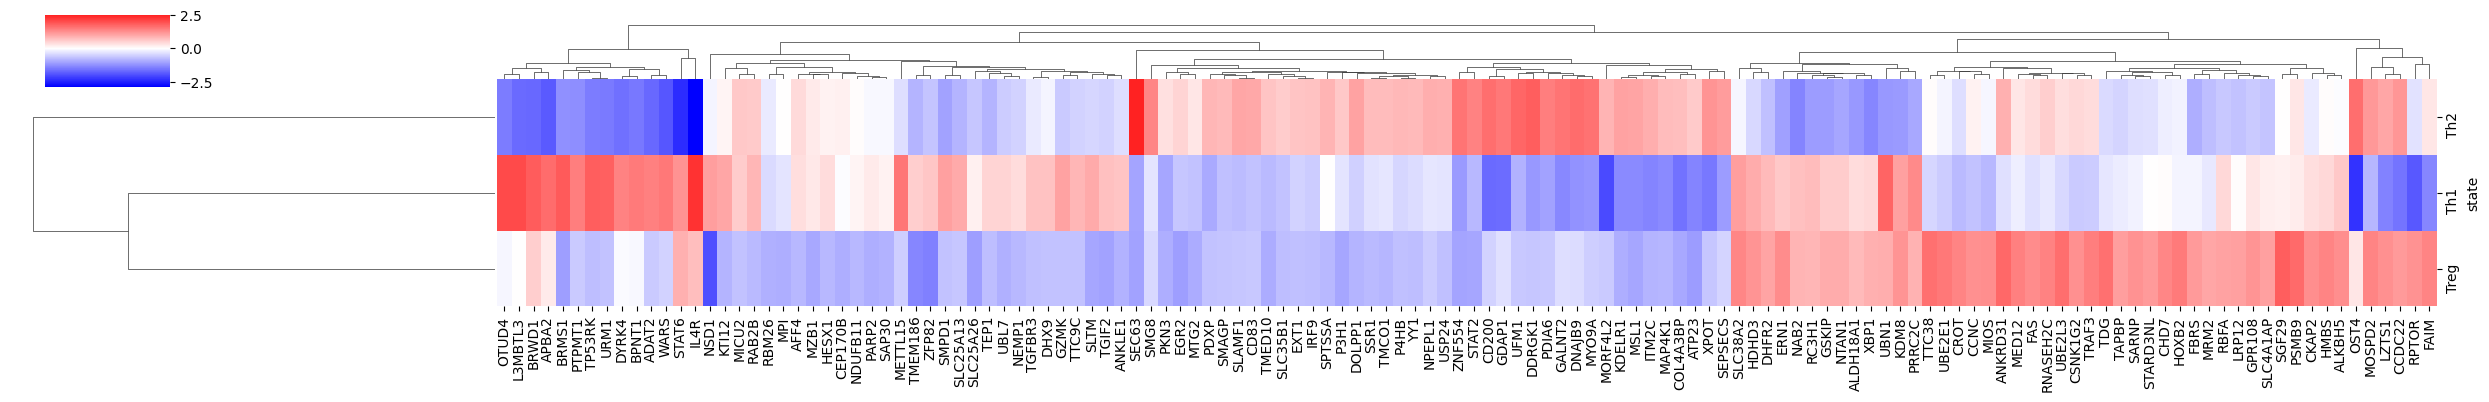

In [259]:
sns.clustermap(coefs_wide.loc[top_genes_list].T, center=0, cmap='bwr', figsize=(25,4), xticklabels=True, z_score=False)

Text(0.5, 1.0, 'Effect of Low Regulators on Most Affected Genes')

<Figure size 1500x2000 with 0 Axes>

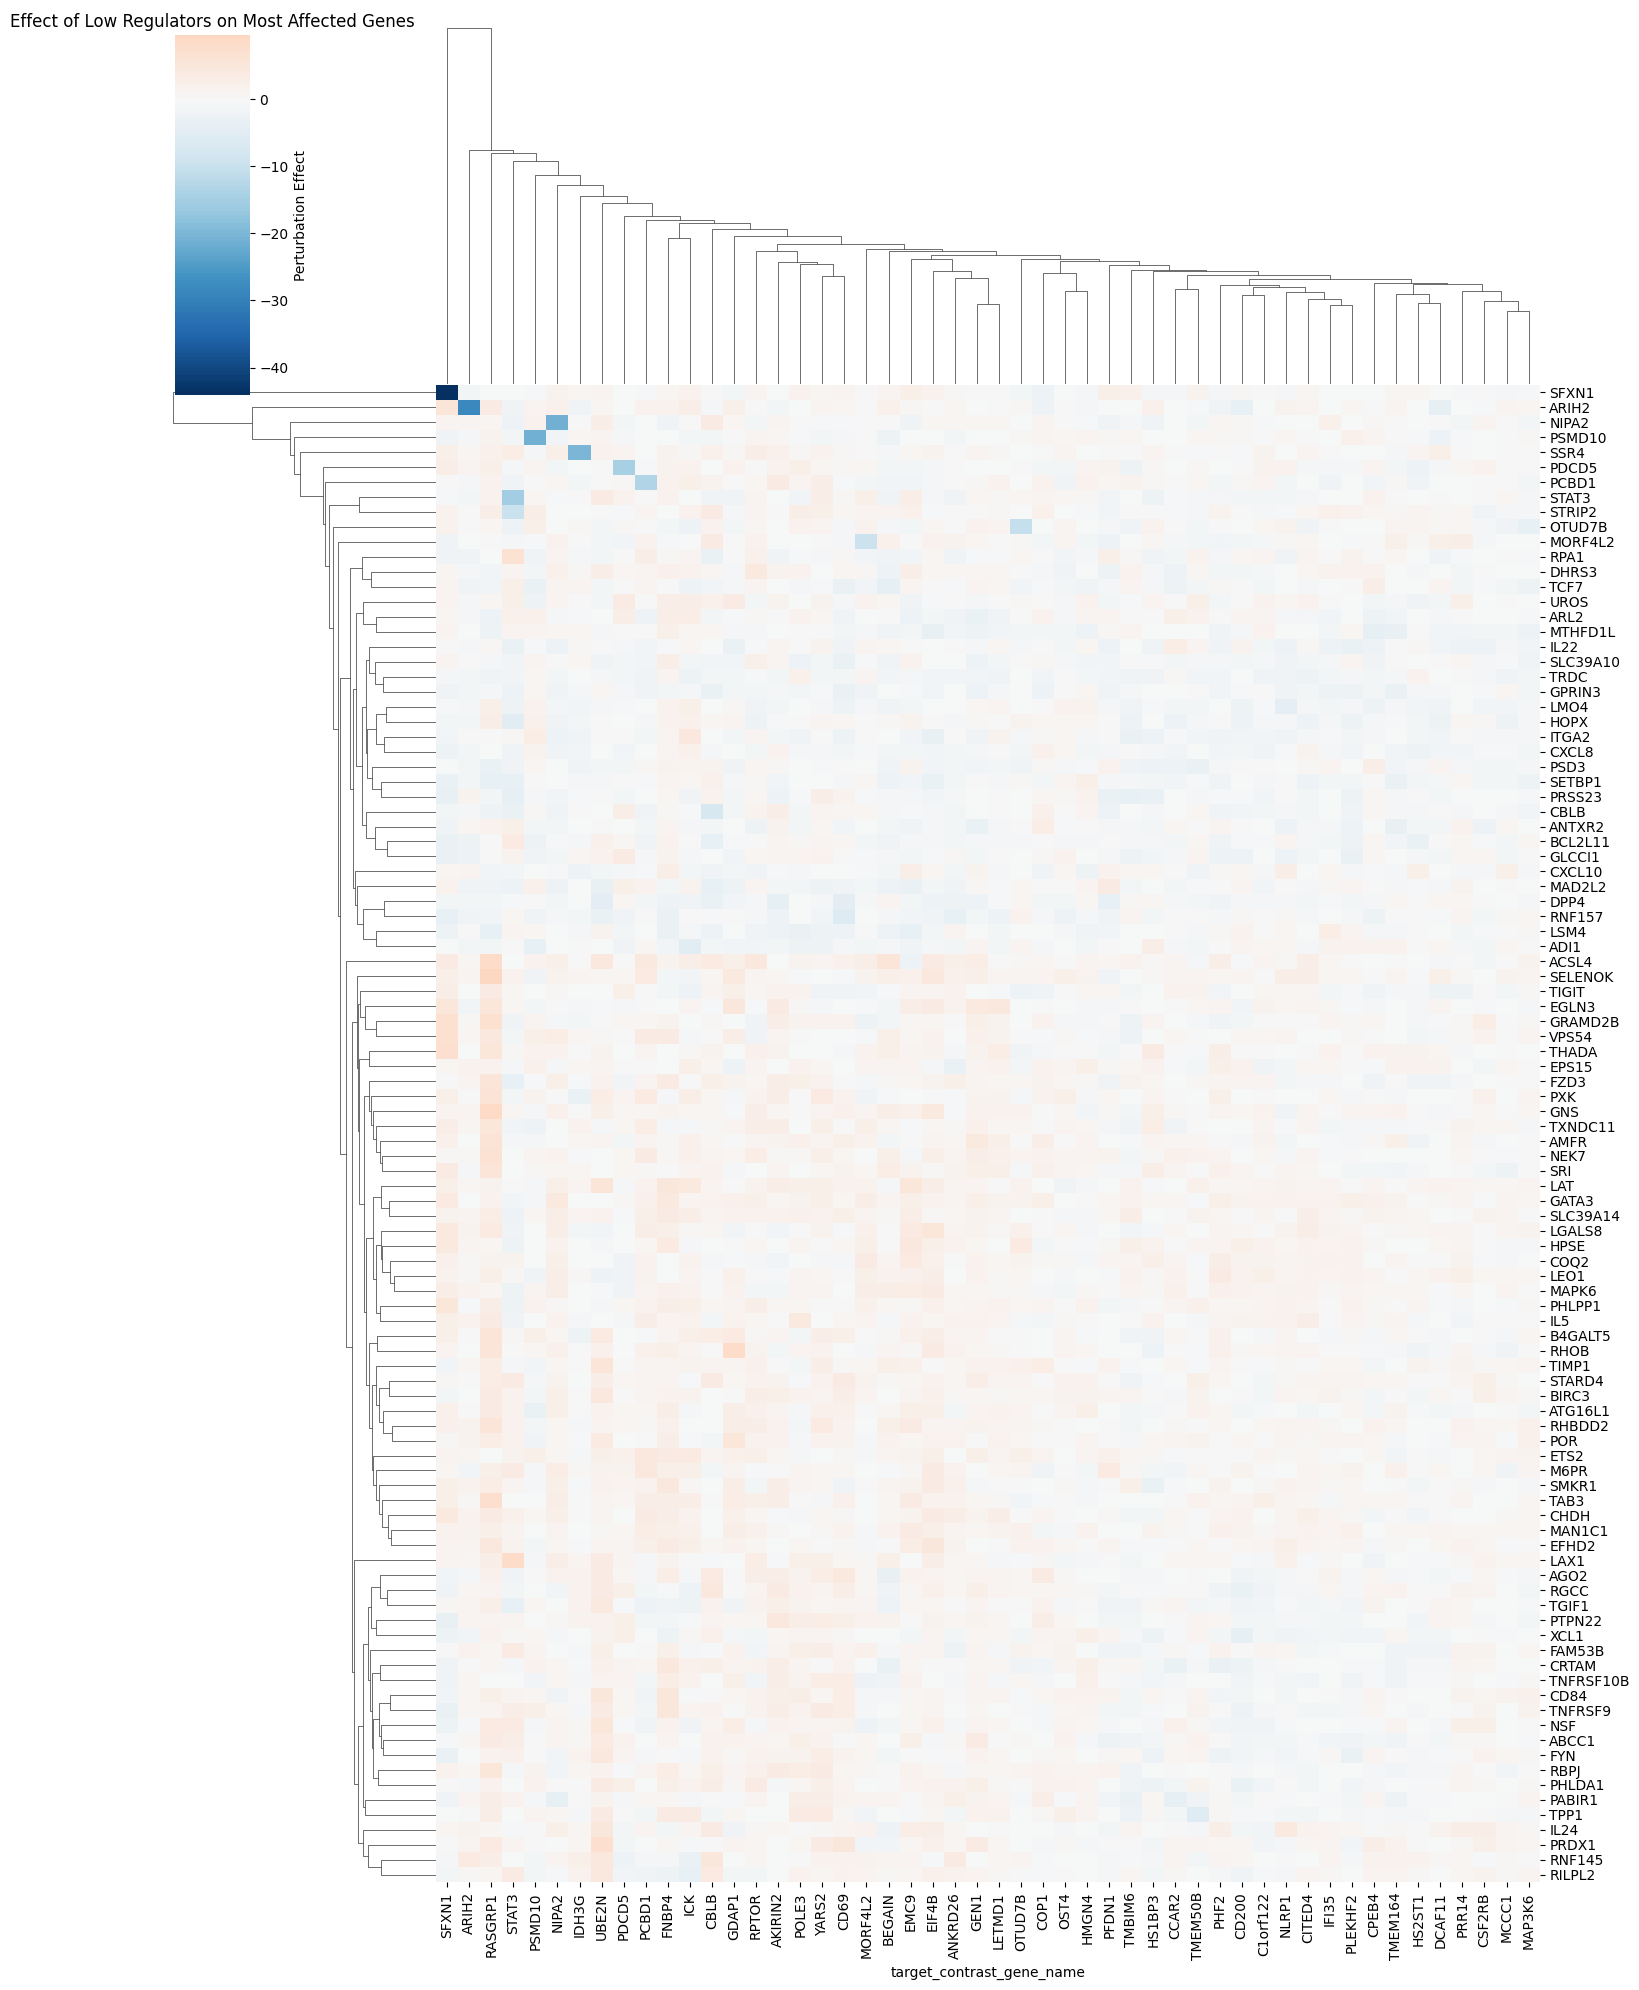

In [38]:
low_regs = coefs_wide['Th1'].sort_values()[0:50].index.tolist()
# Get the perturbation effects for low_regs
perturb_effects = X_perturbs[low_regs]

# Get the 200 genes most affected by these perturbations
# Calculate mean absolute effect across perturbations
mean_effects = perturb_effects.abs().mean(axis=1)
top_affected_genes = mean_effects.nlargest(100).index

# Create clustered heatmap
plt.figure(figsize=(15, 20))
sns.clustermap(perturb_effects.loc[top_affected_genes], 
               center=0,
               cmap='RdBu_r',
               xticklabels=True,
               yticklabels=True,
               figsize=(15, 20),
               cbar_kws={'label': 'Perturbation Effect'})
plt.title('Effect of Low Regulators on Most Affected Genes')

In [759]:
st='Th1'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()
mod_ix = 
comps = pd.DataFrame(p2t_model.pcas[mod_ix].components_, columns=X_perturbs.columns)
top = p2t_model.models[mod_ix].coef_.argmax()
# plt.plot(top, '.')
comps.iloc[top,:].sort_values()

target_contrast_gene_name
GIN1      -0.059474
HELZ      -0.058324
DNTTIP1   -0.055660
CCDC6     -0.055113
AP3M1     -0.053719
             ...   
PHF12      0.049750
SMARCB1    0.050056
ZBTB48     0.050656
SIN3B      0.054089
NSD1       0.091510
Name: 29, Length: 3861, dtype: float64

In [ ]:
st = 'Treg'
p2t_model, p2t_model_k562, X_perturbs, y_target, common_gs = unpack_state_results(model_results, st).values()

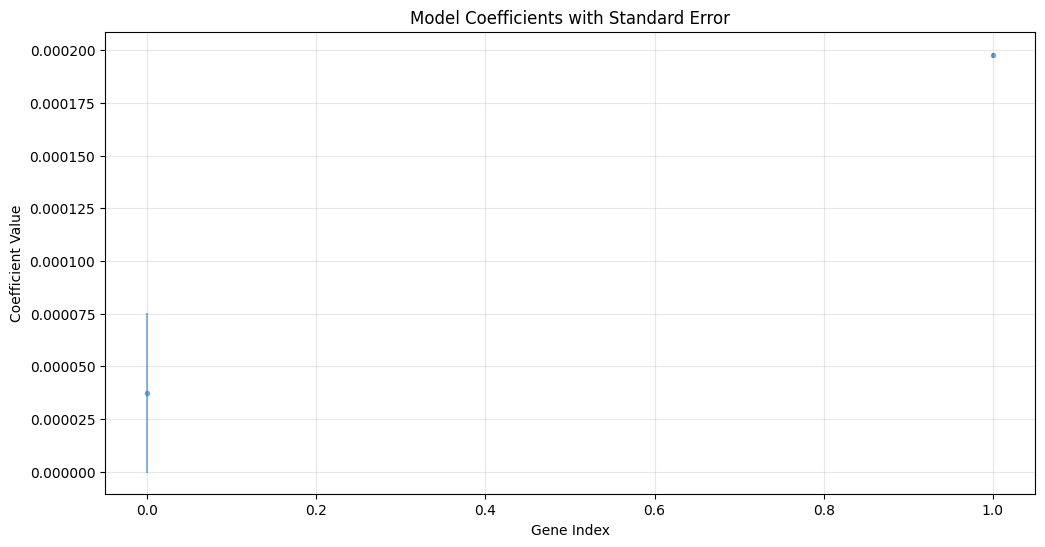

coef_mean  coef_sem
coef_mean   0.000037  0.000038
coef_sem    0.000198  0.000001

In [761]:
coefs = p2t_model.get_coefs()
coefs_mean = coefs.mean(axis=0)
coefs_sem = coefs.sem(axis=0)

# Create DataFrame with mean and SEM
coefs_df = pd.DataFrame({
    'coef_mean': coefs_mean,
    'coef_sem': coefs_sem
})

# Plot mean coefficients with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(coefs_mean)), coefs_mean, yerr=coefs_sem, fmt='.', alpha=0.5)
plt.title('Model Coefficients with Standard Error')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient Value')
plt.grid(True, alpha=0.3)
plt.show()

coefs_df

In [452]:
import decoupler as dc

In [594]:
msigdb_table = decoupler.op.resource('MSigDB')

In [645]:
msigdb_table.collection.value_counts()

collection
immunesigdb                           1211234
go_biological_process                 1028339
human_phenotype_ontology               643992
chemical_and_genetic_perturbations     520915
mirna_targets_mirdb                    468097
tf_targets_gtrf                        278854
reactome_pathways                      207025
tf_targets_legacy                      199207
cell_type_signatures                   193040
go_cellular_component                  177903
go_molecular_function                  176652
cancer_modules                          68839
wikipathways                            59269
vaccine_response                        58531
cancer_gene_neighborhoods               57559
mirna_targets_legacy                    44535
oncogenic_signatures                    39253
kegg_pathways                           27028
positional                              24437
pid_pathways                            16547
hallmark                                11319
biocarta_pathways      

In [669]:
ctsig_table = msigdb_table[msigdb_table.collection == 'kegg_pathways']
immunesig_db_table = msigdb_table[msigdb_table['collection'] == 'immunesigdb']

In [681]:
[x for x in ctsig_table.geneset if 'T_CELL' in x]

['KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY',
 'KEGG_T_CE

In [670]:
net = ctsig_table.rename({'geneset':'source', 'genesymbol':'target'}, axis=1)
net = net.drop_duplicates(subset=['source', 'target'])

In [671]:
input_df = coefs_wide[['Th1']].T
input_df.index.name = None

In [695]:
scores  = decoupler.mt.decouple(coefs_wide[['Th2']].T.abs(), net=net)


AttributeError: 'NoneType' object has no attribute '__name__'

In [689]:
scores.T

Th2
KEGG_ACUTE_MYELOID_LEUKEMIA                      1.319735
KEGG_ADHERENS_JUNCTION                           1.030324
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY             1.289013
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM  1.138446
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION   0.780028
...                                                   ...
KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION    0.702157
KEGG_VEGF_SIGNALING_PATHWAY                      1.202326
KEGG_VIBRIO_CHOLERAE_INFECTION                   1.225944
KEGG_VIRAL_MYOCARDITIS                           0.920714
KEGG_WNT_SIGNALING_PATHWAY                       1.233907

[154 rows x 1 columns]

In [691]:
pvals.T.sort_values('Th2')

Th2
KEGG_JAK_STAT_SIGNALING_PATHWAY               0.308000
KEGG_CHRONIC_MYELOID_LEUKEMIA                 0.435803
KEGG_CYSTEINE_AND_METHIONINE_METABOLISM       0.435803
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION   0.435803
KEGG_DNA_REPLICATION                          0.435803
...                                                ...
KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS  0.994032
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM          0.994032
KEGG_REGULATION_OF_ACTIN_CYTOSKELETON         0.994032
KEGG_CELL_ADHESION_MOLECULES_CAMS             0.994032
KEGG_GLYCOLYSIS_GLUCONEOGENESIS               0.995885

[154 rows x 1 columns]

(None,
 array(['IL4R', 'STAT6', 'STAT2', 'CSF2RB', 'CREBBP', 'EP300', 'AKT3',
        'STAT1', 'STAT3', 'CBLB', 'IL10RA', 'IFNGR2', 'AKT1', 'PTPN11',
        'IRF9', 'STAT5A', 'IFNAR1', 'IL4', 'PIK3CB', 'GRB2', 'CCND2',
        'PIK3CA', 'IL12RB2', 'AKT2', 'PIK3CG'], dtype='<U10'))

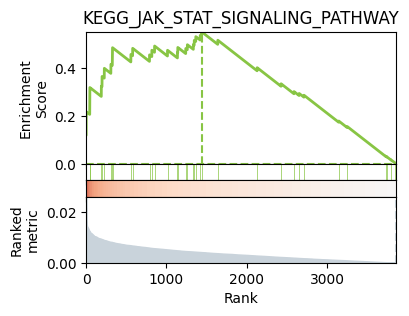

In [693]:
decoupler.pl.leading_edge(coefs_wide.abs(), net=net, stat='Th2', name='KEGG_JAK_STAT_SIGNALING_PATHWAY')

In [562]:
tf_acts

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK      NFkB  \
Treg  0.858993  1.032567  0.904279  1.045801  1.044117  1.086472  1.102279   

          PI3K      TGFb     TNFa     Trail      VEGF       WNT       p53  
Treg  0.977776  0.872948  1.08322 -1.208076  1.095913 -0.798849  0.963823

array([[<Axes: title={'center': 'Treg'}>]], dtype=object)

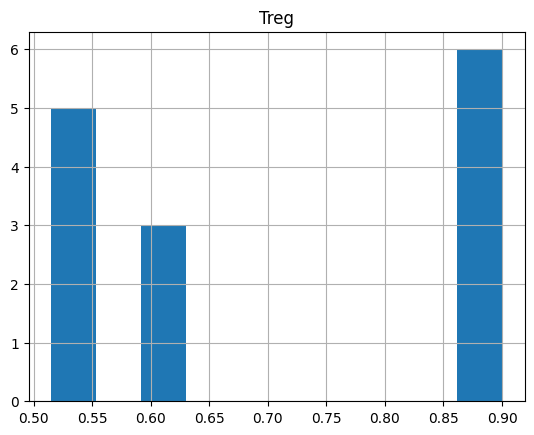

In [561]:
tf_padj.T.hist()

## Check single-cell states 

In [8]:
import glob
stim_sc_files = glob.glob(f'{datadir}/**/*Stim8hr*postQC.h5ad', recursive=True)
# Pick some lanes
stim_sc_files = stim_sc_files[0:10]

In [ ]:
import h5py
import anndata as ad
from tqdm import tqdm

adatas = []
all_highly_variable_genes = []
for f in tqdm(stim_sc_files):
    adata = ad.experimental.read_lazy(f)
    adata_ntc = adata[adata.obs['perturbed_gene_name'] == 'NTC'].copy()

    X_dask = adata_ntc.X
    X_dask = X_dask.map_blocks(lambda x: x.toarray(), dtype=X_dask.dtype, meta=np.array([]))
    col_sums = X_dask.sum(axis=0).compute()  # Compute sum along rows (axis=1)
    gene_mask = col_sums > 2

    adata_ntc = adata_ntc[:, gene_mask].copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    
    highly_variable_genes = set(adata.var_names[adata.var["highly_variable"]])
    all_highly_variable_genes.append(highly_variable_genes)
    adatas.append(adata)

In [45]:
from collections import Counter

## select the genes appears more than two lanes
gene_counts = Counter(gene for genes in all_highly_variable_genes for gene in genes)
selected_genes = {gene for gene, count in gene_counts.items() if count > 2}
print( len(selected_genes) )

for i,a in enumerate(adatas):
    common_genes = list(set(a.var_names) & selected_genes)
    a = a[:, common_genes].copy()
    a.obs = a.obs.to_dataframe()
    a.var = a.var.to_dataframe()
    output_path = f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'
    a.write_h5ad(output_path)

1774


In [47]:
%%time
data_dict = {}
for i,_ in enumerate(adatas):
    data_dict.update({i:f'{datadir}/tmp/Stim8hr_NTCs_preprocessed_s{i}.h5ad'})

ad.experimental.concat_on_disk(
    data_dict,
    f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad',
    label='sample_id',
)

CPU times: user 3.22 s, sys: 2.65 s, total: 5.87 s
Wall time: 12.7 s


In [61]:
adata = sc.read_h5ad(f'{datadir}/tmp/Stim8hr_NTCs_merged.h5ad', backed=False)

In [63]:
sc.pp.pca(adata, n_comps=50)

In [86]:
adata.var = a.var[['gene_ids', 'gene_name']].loc[adata.var_names].copy()

In [87]:
adata.var_names = adata.var['gene_name'].values

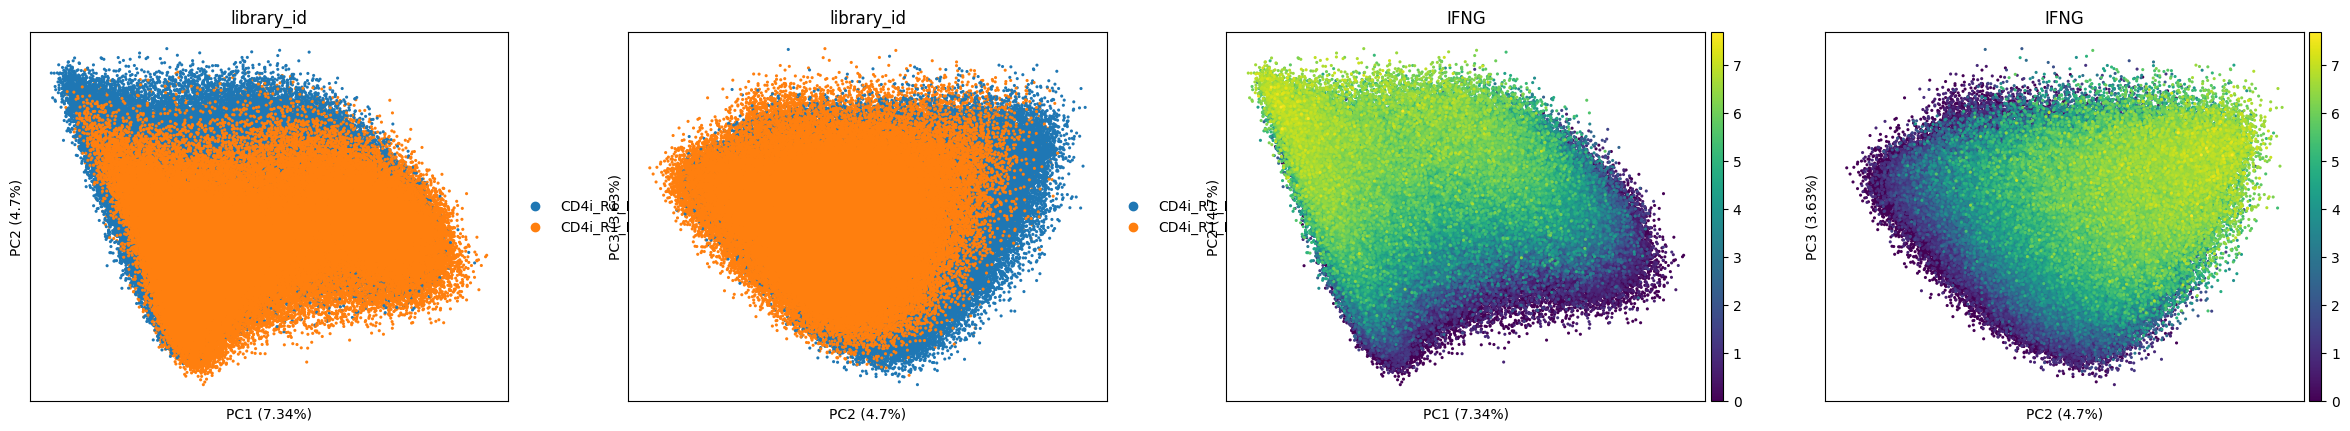

In [92]:
sc.pl.pca(adata, annotate_var_explained=True, color=['library_id', 'IFNG'], size=20, components=['1,2', '2,3'])

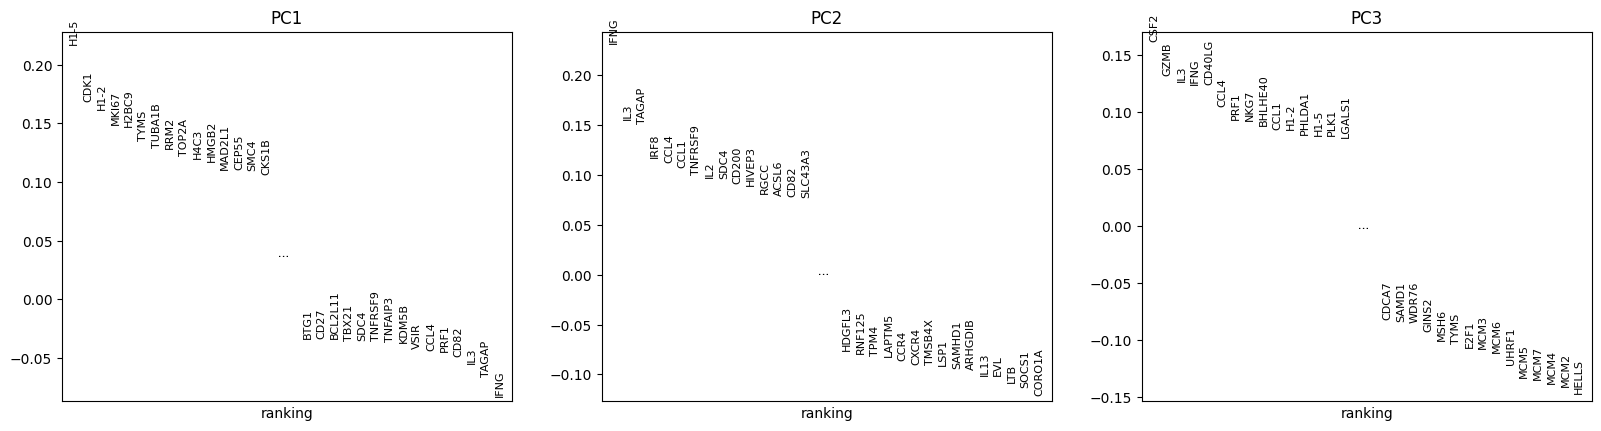

In [90]:
sc.pl.pca_loadings(adata)

In [327]:
target_hits = get_DE_results_long(adata_de, targets=['GATA3'])
target_hits = target_hits[target_hits['culture_condition'] == cond]
signif_genes = target_hits[target_hits['significant']]
signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')
signif_gene_classes = signif_genes.groupby('class')['gene'].apply(list).to_dict()
signif_gene_classes

/tmp/ipykernel_2698264/4045715312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_genes['class'] = np.where(np.sign(target_hits[target_hits['significant']].zscore) < 0, 'neg', 'pos')


{'neg': ['ADAM19',
  'ANXA4',
  'ATP8B2',
  'CD44',
  'CLINT1',
  'CYLD',
  'EEIG1',
  'EML4',
  'ERN1',
  'GIMAP4',
  'GLUL',
  'ICAM2',
  'IFITM2',
  'IKZF1',
  'IL10RA',
  'IL32',
  'KLF2',
  'MORC2',
  'MYD88',
  'NME2',
  'NSA2',
  'PXN',
  'RASA3',
  'S100A10',
  'S100A11',
  'SAMD3',
  'SLFN5',
  'SOS1',
  'TNFSF10'],
 'pos': ['ADA',
  'CD3G',
  'CD7',
  'CD74',
  'CYFIP2',
  'FTH1',
  'GRK2',
  'HMGN1',
  'LBR',
  'MAL',
  'MAP4K4',
  'NHERF1',
  'RABL6',
  'SEPTIN6',
  'SNRPC',
  'STAU2',
  'YBX1']}

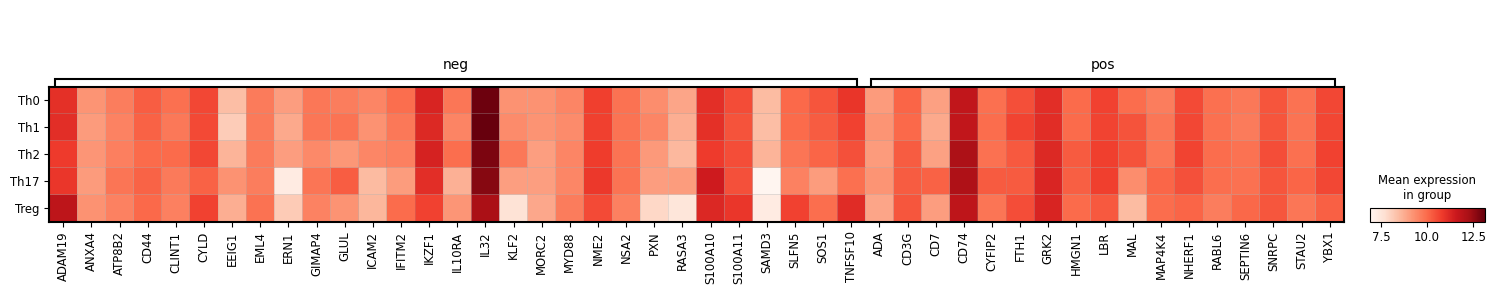

In [331]:
sc.pl.matrixplot(pbulk_adata[pbulk_adata.obs.culture_condition != 'Day0'], signif_gene_classes, groupby='culture_condition', cmap='Reds')

In [137]:
# Store evaluation results for different numbers of PCs
pc_eval_results = []

from tqdm.notebook import tqdm
for d in tqdm(np.linspace(10,100, 10), desc="Testing different PC counts"):
    p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=int(d), n_splits=3, n_repeats=3)
    p2t_model.fit(X_perturbs, y_target, model_id=f'Stim8hr_PC{int(d)}', frac_top_hvgs=0.50)
    
    # Get evaluation summary
    eval_summary = p2t_model.summarize_eval()
    eval_summary['n_pcs'] = int(d)
    
    # Store results
    pc_eval_results.append(eval_summary)


Testing different PC counts:   0%|          | 0/10 [00:00<?, ?it/s]

Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes
Training on 3170/6341 genes


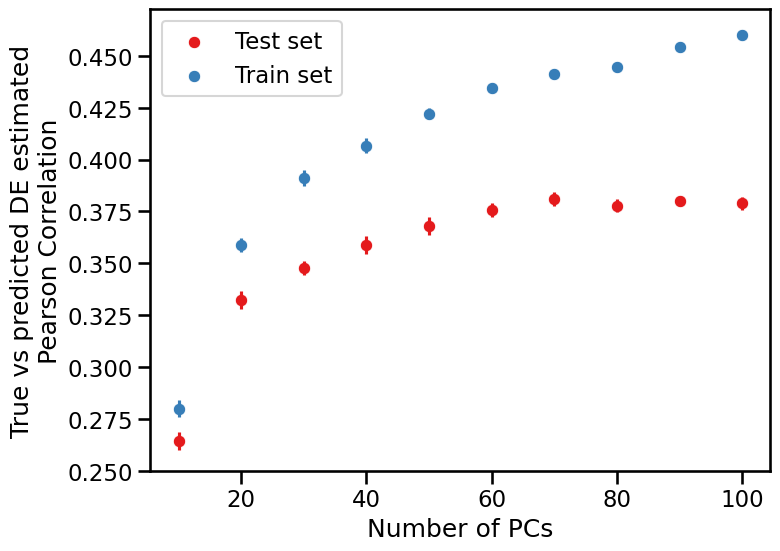

In [143]:
sns.set_context('talk')
# Combine all results into a single DataFrame
pc_eval_df = pd.concat(pc_eval_results)
# Create a figure with error bars showing standard error
fig, ax = plt.subplots(figsize=(8, 6))

# Use Set1 color palette
palette = sns.color_palette("Set1")

# Test pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='test_pearson', label='Test set', ax=ax, color=palette[0])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['test_pearson'], 
            yerr=pc_eval_df['test_pearson_se'], fmt='none', alpha=1, color=palette[0])

# Train pearson with matching color for points and error bars
sns.scatterplot(data=pc_eval_df, x='n_pcs', y='train_pearson', label='Train set', ax=ax, color=palette[1])
ax.errorbar(pc_eval_df['n_pcs'], pc_eval_df['train_pearson'], 
            yerr=pc_eval_df['train_pearson_se'], fmt='none', alpha=1, color=palette[1])

plt.xlabel('Number of PCs')
plt.ylabel('True vs predicted DE estimated\nPearson Correlation')
plt.legend()

### Simple correlation

Text(0.5, 1.0, 'Correlation: r = -0.164, p = 6.429e-43')

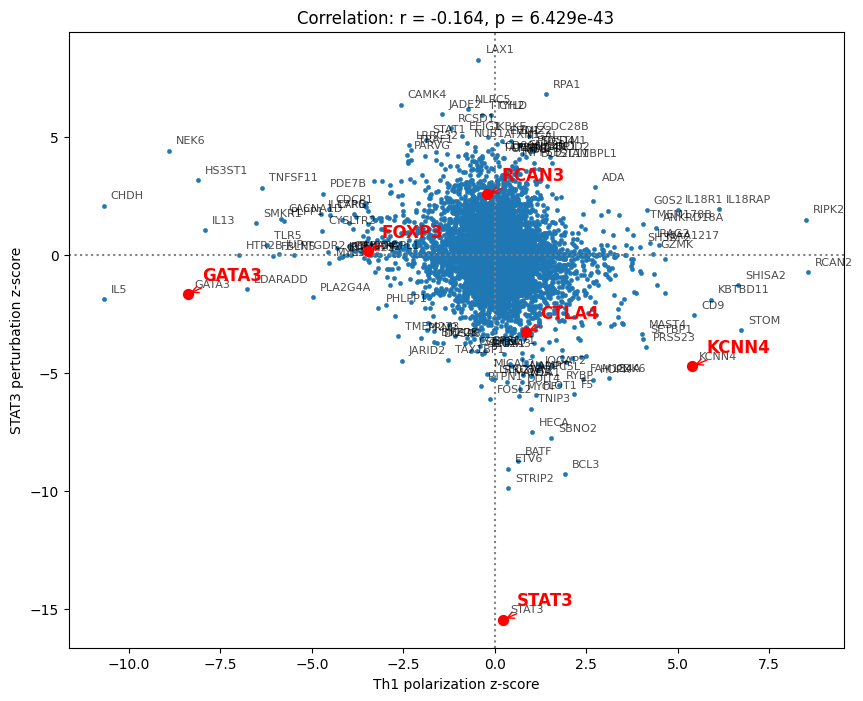

In [283]:
pseq_target = 'STAT3'
pol_condition = 'Th1'

perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results = perturbseq_results.set_index('gene_name')[['zscore', 'culture_condition']]
perturbseq_results = perturbseq_results[perturbseq_results['culture_condition'] == 'Stim8hr' ].copy()

polarization_results = all_results_df[all_results_df['contrast'] == pol_condition].set_index('variable')
polarization_results = polarization_results.rename({'zscore': 'zscore_polarization'}, axis=1)
compare_df = pd.concat([perturbseq_results, polarization_results], axis=1).dropna()

# Calculate correlation coefficient and p-value
from scipy import stats
corr, p_value = stats.pearsonr(compare_df['zscore_polarization'], compare_df['zscore'])

# Create scatter plot with correlation and p-value in title
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=compare_df, x='zscore_polarization', y='zscore', s=10, edgecolor=None, ax=ax)

# Add quadrant lines
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.axvline(x=0, linestyle='dotted', color='gray')

# Annotate top genes in each quadrant
# Get top 5 genes by absolute distance from origin in each quadrant
for quadrant in ['top_right', 'top_left', 'bottom_right', 'bottom_left']:
    if quadrant == 'top_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['zscore'] > 0)
    elif quadrant == 'top_left':
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['zscore'] > 0)
    elif quadrant == 'bottom_right':
        mask = (compare_df['zscore_polarization'] > 0) & (compare_df['zscore'] < 0)
    else:  # bottom_left
        mask = (compare_df['zscore_polarization'] < 0) & (compare_df['zscore'] < 0)
    
    quadrant_df = compare_df[mask].copy()
    if len(quadrant_df) > 0:
        # Calculate distance from origin
        quadrant_df['distance'] = np.sqrt(quadrant_df['zscore_polarization']**2 + quadrant_df['zscore']**2)
        # Get top 5 genes
        top_genes = quadrant_df.nlargest(30, 'distance')
        
        # Annotate points
        for idx, row in top_genes.iterrows():
            ax.annotate(idx, 
                       (row['zscore_polarization'], row['zscore']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)

# Highlight and annotate CTLA4 and FOXP3
highlight_genes = ['CTLA4', 'FOXP3', 'KCNN4', 'RCAN3', 'STAT3', 'GATA3']
for gene in highlight_genes:
    if gene in compare_df.index:
        row = compare_df.loc[gene]
        # Plot highlighted point
        ax.scatter(row['zscore_polarization'], row['zscore'], 
                  color='red', s=50, zorder=3)
        # Add annotation with arrow
        ax.annotate(gene,
                   (row['zscore_polarization'], row['zscore']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=12, fontweight='bold',
                   color='red',
                   arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel(f'{pol_condition} polarization z-score')
plt.ylabel(f'{pseq_target} perturbation z-score')
plt.title(f'Correlation: r = {corr:.3f}, p = {p_value:.3e}')

In [236]:
pseq_target = 'GATA3'
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore', 'log_fc'])
perturbseq_results[ perturbseq_results['significant'] ]

index     gene    zscore    log_fc  adj_p_value  \
45        ENSG00000107485_Rest    ABHD3  3.134213  0.280295     0.052651   
58        ENSG00000107485_Rest   ABRACL -2.918213 -0.187295     0.079782   
102       ENSG00000107485_Rest    ACOX3  3.547358  0.750618     0.019155   
125       ENSG00000107485_Rest   ACTR1A  2.956265  0.199357     0.075256   
138       ENSG00000107485_Rest      ADA  3.608786  0.455327     0.016035   
...                        ...      ...       ...       ...          ...   
20022  ENSG00000107485_Stim8hr   ZNF664 -3.559065 -0.280524     0.019270   
20081  ENSG00000107485_Stim8hr   ZNF792 -2.802688 -0.890283     0.089452   
20090  ENSG00000107485_Stim8hr   ZNF827  3.623823  0.757133     0.015924   
20129  ENSG00000107485_Stim8hr  ZSCAN22 -3.156376 -0.907989     0.044912   
20154  ENSG00000107485_Stim8hr   ZYG11B -4.405778 -0.933631     0.001501   

       significant gene_name culture_condition  target_contrast  \
45            True     ABHD3              Rest  ENSG00000107485   
58            True    ABRACL              Rest  ENSG00000107485   
102           True     ACOX3              Rest  ENSG00000107485   
125           True    ACTR1A              Rest  ENSG00000107485   
138           True       ADA              Rest  ENSG00000107485   
...            ...       ...               ...              ...   
20022         True    ZNF664           Stim8hr  ENSG00000107485   
20081         True    ZNF792           Stim8hr  ENSG00000107485   
20090         True    ZNF827           Stim8hr  ENSG00000107485   
20129         True   ZSCAN22           Stim8hr  ENSG00000107485   
20154         True    ZYG11B           Stim8hr  ENSG00000107485   

      target_contrast_gene_name  
45                        GATA3  
58                        GATA3  
102                       GATA3  
125                       GATA3  
138                       GATA3  
...                         ...  
20022                     GATA3  
20081                     GATA3  
20090                     GATA3  
20129                     GATA3  
20154                     GATA3  

[896 rows x 10 columns]

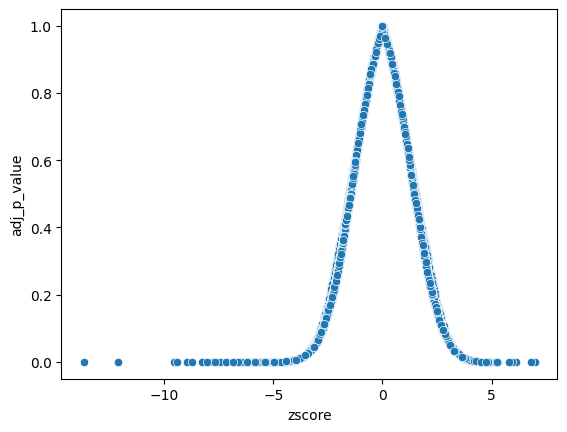

In [239]:
sns.scatterplot(data=perturbseq_results, x='zscore', y='adj_p_value');

In [182]:
df = all_results_df[all_results_df['contrast'] == 'Treg']
df.set_index('variable').loc['CTLA4']

baseMean       2840.803695
log_fc            1.807931
lfcSE             0.252782
stat              7.152129
p_value                0.0
adj_p_value            0.0
contrast              Treg
zscore            7.152129
Name: CTLA4, dtype: object

In [120]:
pseq_target = 'MTOR'
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').groupby('culture_condition').significant.value_counts()

Series([], Name: count, dtype: int64)

In [88]:
perturbseq_results = get_DE_results_long(adata_de, targets=[pseq_target], effect_estimates=['zscore'])
perturbseq_results.set_index('gene_name').loc['FOXP3']

index   gene    zscore  adj_p_value  significant  \
gene_name                                                                       
FOXP3      ENSG00000049768_Stim8hr  FOXP3 -4.610460     0.022389         True   
FOXP3         ENSG00000049768_Rest  FOXP3 -3.431448     0.999792        False   

          culture_condition  target_contrast target_contrast_gene_name  
gene_name                                                               
FOXP3               Stim8hr  ENSG00000049768                     FOXP3  
FOXP3                  Rest  ENSG00000049768                     FOXP3

In [263]:
adata_de.var_names = adata_de.var['gene_name'].copy()
# Create a dictionary to store correlation results for all polarization conditions
all_correlation_results = {}

# Loop through all polarization conditions
for pol_condition in all_results['contrast'].unique():
    polarization_results = all_results[all_results['contrast'] == pol_condition].set_index('variable')
    polarization_results['zscore_polarization'] = polarization_results['log_fc'] / polarization_results['lfcSE']
    
    common_gs = np.intersect1d(polarization_results.index, adata_de.var['gene_name'])
    
    polarization_results = polarization_results.loc[common_gs].copy()
    pseq_results = pd.DataFrame(adata_de[:, common_gs].layers['zscore'], columns=common_gs, index=adata_de.obs_names)
    
    # Compute correlation coefficient and p-value for each row in pseq_results
    correlation_results = {}
    for idx in pseq_results.index:
        row_data = pseq_results.loc[idx]
        corr, p_value = stats.pearsonr(polarization_results['zscore_polarization'], row_data)
        correlation_results[idx] = {'correlation': corr, 'p_value': p_value, 'polarization': pol_condition}
    
    # Store results for this polarization condition
    all_correlation_results[pol_condition] = correlation_results

# Convert all results to a single DataFrame
correlation_dfs = []
for pol_condition, results in all_correlation_results.items():
    df = pd.DataFrame(results).T
    df.columns = ['correlation', 'p_value', 'polarization']
    correlation_dfs.append(df)

correlation_df = pd.concat(correlation_dfs)
correlation_df['target_gene_name'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'target_contrast_gene_name'])
correlation_df['condition'] = correlation_df.index.map(lambda x: adata_de.obs.loc[x, 'culture_condition'])

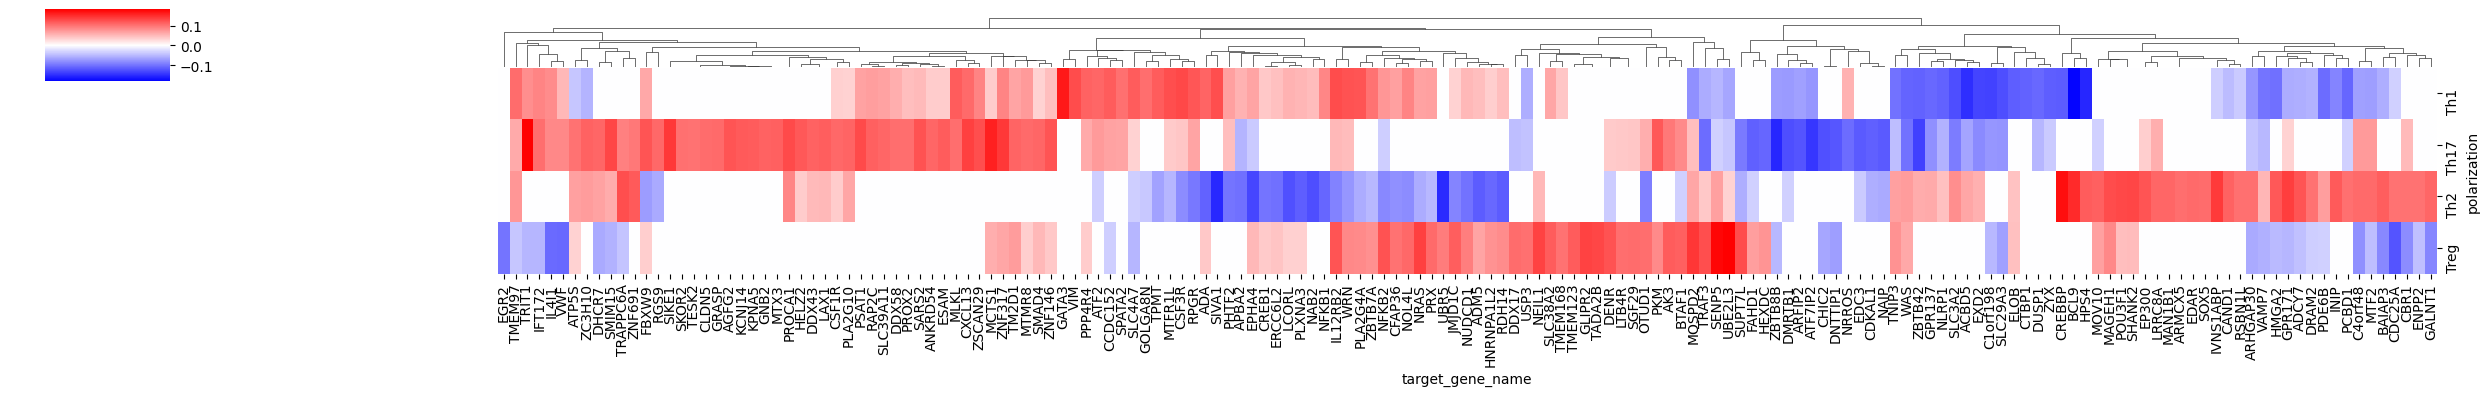

In [295]:
corr_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='correlation', columns='polarization')
pval_wide = correlation_df.pivot_table(index=['target_gene_name', 'condition'], values='p_value', columns='polarization')
corr_wide[pval_wide >= 0.01] = 0
corr_wide = corr_wide.reset_index()
corr_wide = corr_wide[corr_wide['condition'] == 'Stim8hr'].drop('condition', axis=1).set_index('target_gene_name')

sns.clustermap(corr_wide[corr_wide.abs().max(1) > 0.1].astype(float).T, cmap='bwr', center=0, figsize=(25,4), xticklabels=True, row_cluster=False)

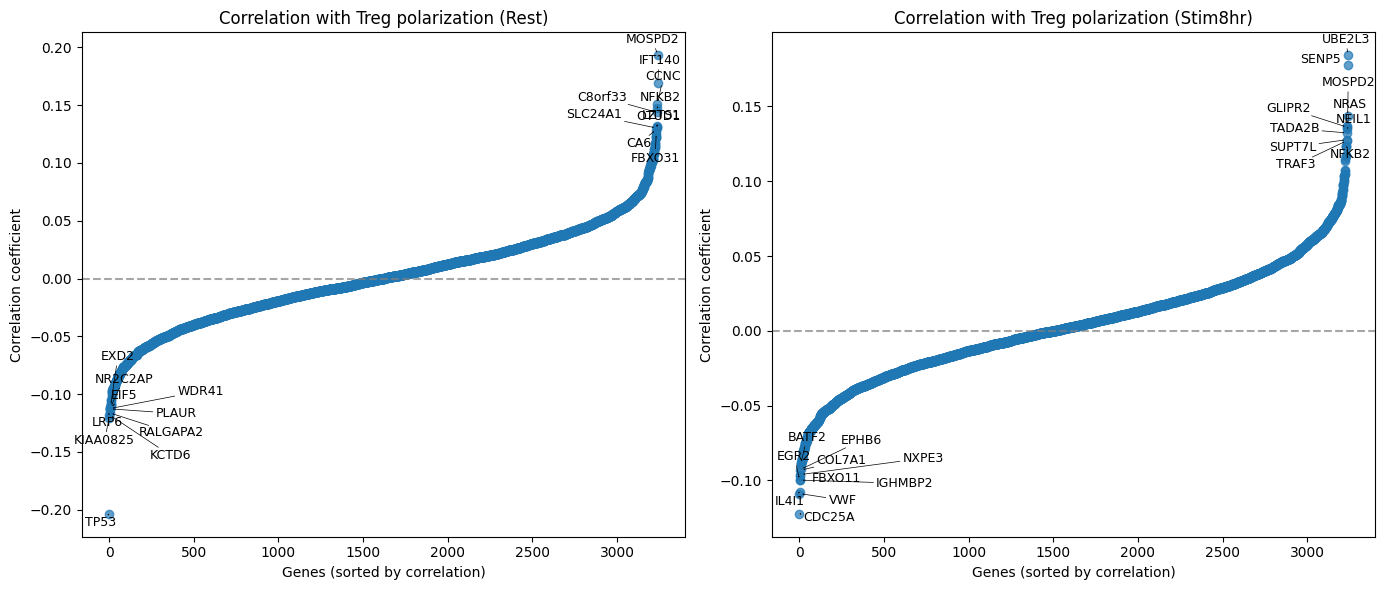

In [261]:
from adjustText import adjust_text
# Create a figure with 2 subplots (one for each condition)
ntop = 10
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
conditions = correlation_df['condition'].unique()

for i, condition in enumerate(conditions):
    # Filter data for this condition
    condition_df = correlation_df[correlation_df['condition'] == condition].copy()
    condition_df = condition_df.sort_values('correlation')
    
    # Create scatterplot
    axes[i].scatter(range(len(condition_df)), condition_df['correlation'], alpha=0.7)
    
    # Get top and bottom genes to annotate
    top_genes = condition_df.nlargest(ntop, 'correlation')
    bottom_genes = condition_df.nsmallest(ntop, 'correlation')
    genes_to_annotate = pd.concat([top_genes, bottom_genes])
    
    # Annotate points with adjustText to avoid overlaps
    texts = []
    for _, row in genes_to_annotate.iterrows():
        idx = condition_df.index.get_loc(row.name)
        text = axes[i].text(idx, row['correlation'], row['target_gene_name'], 
                          fontsize=9, ha='center', va='center')
        texts.append(text)
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=axes[i])
    
    # Add horizontal line at y=0
    axes[i].axhline(y=0, linestyle='--', color='gray', alpha=0.7)
    
    # Set title and labels
    axes[i].set_title(f'Correlation with {pol_condition} polarization ({condition})')
    axes[i].set_xlabel('Genes (sorted by correlation)')
    axes[i].set_ylabel('Correlation coefficient')

plt.tight_layout()